In [1]:
import os, json, sys

sys.path.append(os.path.join('..','Assets','python'))

import numpy               as np
import matplotlib.pyplot   as plt
import matplotlib.patches  as patch
import matplotlib          as mpl
import pandas              as pd
from matplotlib            import cm
from matplotlib.colors     import LinearSegmentedColormap
from global_data           import run_years

In [2]:
def load_infection_data_from_path(expname):
    tpath = os.path.join('..',expname)
    with open(os.path.join(tpath,'data_brick.json')) as fid01:
        data_brick = json.load(fid01)

    with open(os.path.join(tpath,'param_dict.json')) as fid01:
        param_dict = json.load(fid01)

    mydf = process_outputs(data_brick, param_dict)
    return mydf
    
def process_outputs(data_brick, param_dict):
    processed_dict = preprocess_dict(param_dict['EXP_VARIABLE'])
    df = pd.DataFrame().from_dict(processed_dict)
    
    
    nsims = int(param_dict['NUM_SIMS'])
    #ref_year = param_dict['EXP_CONSTANT']['start_year']
    df['timeseries'] = None
    df['age_hists']  = None
    df['pop_data']  = None
    for key in data_brick.keys():
        df.at[df.index[df['run_number']==int(key)][0], 'timeseries'] = np.array(data_brick[key]['timeseries'])
        df.at[df.index[df['run_number']==int(key)][0], 'age_hists'] = np.array(data_brick[key]['age_data'])
        df.at[df.index[df['run_number']==int(key)][0], 'pop_data'] = np.array(data_brick[key]['pyr_data'])
    return df

def preprocess_dict(d):
    allkeys = ['run_number','R0', 'MCV1', 'MCV1_age', 'mat_factor_inf', 'mat_factor_vx', 'mat_duration', 'MCV2', 'MCV2_age', 'start_year', 'timeliness_distribution', 'Ageind_vx_model']
    defaults = {'run_number':0,
                'R0' :16.0, 
                'MCV1': 0.0, 
                'MCV1_age': 270.0, 
                'mat_factor_inf': 1.0, 
                'mat_factor_vx': 0.4, 
                'mat_duration': 120.0,
                'MCV2': 0.0, 
                'MCV2_age': 1.25*365.0,
                'start_year': 2040.0,
                'timeliness_distribution': True,
                'Ageind_vx_model': False}
    # Ensure all keys are present in the dictionary, fill with default if not
    return {key: d.get(key, [defaults[key]] * len(next(iter(d.values())))) for key in allkeys}


In [3]:
df = load_infection_data_from_path('experiment_sweepAAV')
df = pd.concat([df, load_infection_data_from_path('experiment_sweepAAV_MCV2')], ignore_index=True)
df = pd.concat([df, load_infection_data_from_path('experiment_sweepAAV_longmAbs')], ignore_index=True)
df = pd.concat([df, load_infection_data_from_path('experiment_sweepAAV_demographics')], ignore_index=True)
df = pd.concat([df, load_infection_data_from_path('experiment_sweepAAV_longmAbs_MCV2')], ignore_index=True)
df = pd.concat([df, load_infection_data_from_path('experiment_sweepAAV_mAbinterference')], ignore_index=True)
df = pd.concat([df, load_infection_data_from_path('experiment_sweepAAV_mAbinterference_mCV2')], ignore_index=True)
df = pd.concat([df, load_infection_data_from_path('experiment_sweepAAV_timeliness')], ignore_index=True)
df = pd.concat([df, load_infection_data_from_path('experiment_sweepAAV_Vxmodel')], ignore_index=True)
df = pd.concat([df, load_infection_data_from_path('experiment_sweepAAV_MCV2age')], ignore_index=True)


In [4]:
def process_infection_data(df):
    df['tpop_avg'] = df['pop_data'].apply(lambda x: np.sum(x, axis=1))
    df['tpop_xval']   = df['tpop_avg'].apply(lambda x: np.arange(len(x)))
    xval        = np.arange(0,run_years,1/12) + 1/24
    df['pops'] = df.apply(lambda row: np.interp(xval, row['tpop_xval'], row['tpop_avg']), axis=1)
    df['Inf_mean'] = df['timeseries'].apply(lambda x: x[120:].mean())
    df['Inf_mean_nrm'] = df.apply(lambda row: np.mean((12e5*row['timeseries']/row['pops'])[120:]), axis=1)
    return df

In [5]:
df = process_infection_data(df)

In [6]:
allkeys = ['R0', 'MCV1', 'MCV1_age', 'mat_factor_inf', 'mat_factor_vx', 'mat_duration', 'MCV2', 'MCV2_age', 'start_year', 'timeliness_distribution', 'Ageind_vx_model']
grouped_df = df.groupby(allkeys)[['Inf_mean_nrm', 'Inf_mean']].mean().reset_index()


In [7]:
age_hist_bins = [i/12.0 for i in range(25)] + [2.25+i/4 for i in range(12)] + [6+i for i in range(24)]

In [8]:
len(age_hist_bins)

61

In [9]:
df['age_hists_mean'] = df['age_hists'].apply(lambda x: x[10:, :].mean(axis=0))

In [10]:
allkeys = ['R0', 'MCV1', 'MCV1_age', 'mat_factor_inf', 'mat_factor_vx', 'mat_duration', 'MCV2', 'MCV2_age', 'start_year', 'timeliness_distribution', 'Ageind_vx_model']
age_df = df.groupby(allkeys)['age_hists_mean'].mean().reset_index()

In [11]:
grouped_df = pd.merge(grouped_df, age_df, on=list(set(grouped_df.columns) & set(age_df.columns)))


In [12]:
df.loc[0]['timeseries'].sum()

927075.0

In [13]:
# add burden now
cfrs = pd.read_csv('cfr_estimates_all.csv')
cfrs = cfrs[cfrs['country'] == 'NGA']
cfr_ages = list(cfrs['age'])
cfr_pred = list(cfrs['predicted_cfr'])
cfr_ulim = list(cfrs['predicted_cfr_ub'])
cfr_llim = list(cfrs['predicted_cfr_lb'])

interpolated_ifr = np.interp(np.array(age_hist_bins[:-1])/2 + np.array(age_hist_bins[1:])/2, cfr_ages, cfr_pred)

def calculate_fatalities(row, interpolated_ifr):
    # Ensure the length matches
    if len(row) == len(interpolated_ifr):
        return np.sum(row * interpolated_ifr)
    else:
        return np.nan  # or some error handling
    
grouped_df['estimated_fatalities'] = grouped_df['age_hists_mean'].apply(calculate_fatalities, args=(interpolated_ifr,))
grouped_df['estimated_fatalities_nrm'] = 1/12*grouped_df['estimated_fatalities']*grouped_df['Inf_mean_nrm']/grouped_df['Inf_mean']

In [14]:
grouped_df.to_pickle('pickled_sim_outputs.pkl')

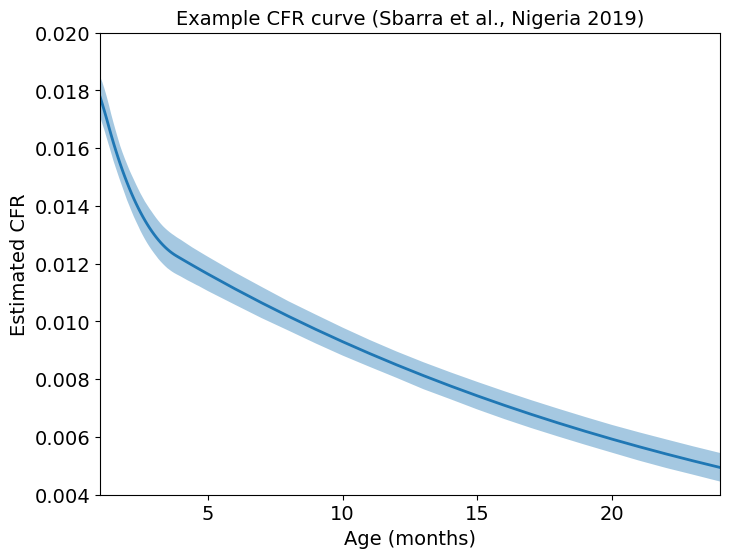

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(cfr_ages, cfr_pred, '-')
ax.fill_between(cfr_ages, cfr_llim, cfr_ulim, alpha=0.4)
ax.set_xlim(1, 24)
ax.set_ylim(0.004, 0.02)
ax.set_ylabel('Estimated CFR')
ax.set_xlabel('Age (months)')
ax.set_title('Example CFR curve (Sbarra et al. model, Nigeria 2019)')
fig.savefig('example_CFR.svg', format='svg', dpi=1000)


# Figure making section

In [37]:
#Set plotting defaults
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=16)   #title fontsize
plt.rc('lines', markersize=8)
plt.rc('lines', linewidth=2)

In [62]:
def line_plot_age(selected_rows, MCV1vals, var2plot='Inf_mean_nrm'):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Get unique values of 'MCV1' to plot separate lines
    mycmap = plt.get_cmap('Blues', 5+len(MCV1vals))
    i = 4
    for mcv1_value in MCV1vals:
        i = i+1
        # Filter rows for each MCV1 value
        subset = selected_rows[selected_rows['MCV1'] == mcv1_value].reset_index()

        # Sort rows by 'MCV1_age' to get a proper line plot
        subset = subset.sort_values('MCV1_age')

        # Plot 'Infs' vs. 'MCV1_age' for the current MCV1 value
        ax.plot(subset['MCV1_age'], (subset[var2plot]), label=f'Cov. = {int(100*mcv1_value)}%', 
               color=mycmap(i))
        yv = np.min(subset[var2plot])
        xv = np.argmin(subset[var2plot])
        ax.plot(subset['MCV1_age'][xv], yv, 'k.')

    # Set the title and labels
    ax.set_title('Infections vs. age at MCV1 vaccination')
    ax.set_xlabel('Age (months)', fontsize=14)
    ax.set_ylabel('Mean infections per year per 100k')
    ax.set_xticks([30.5*i for i in range(3, 16)])
    ax.set_xticklabels([str(i) for i in range(3, 16)])
    ax.tick_params(axis='y', which='major')

    # Show legend
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    return (fig, ax)


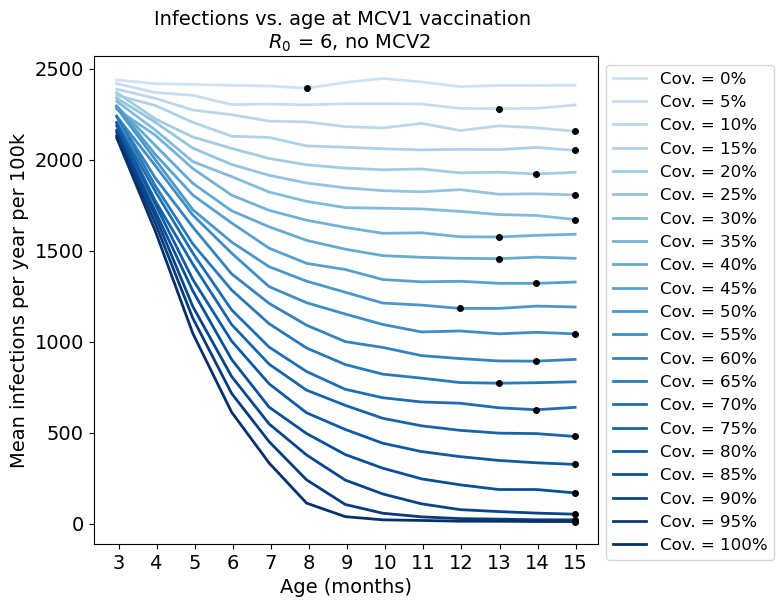

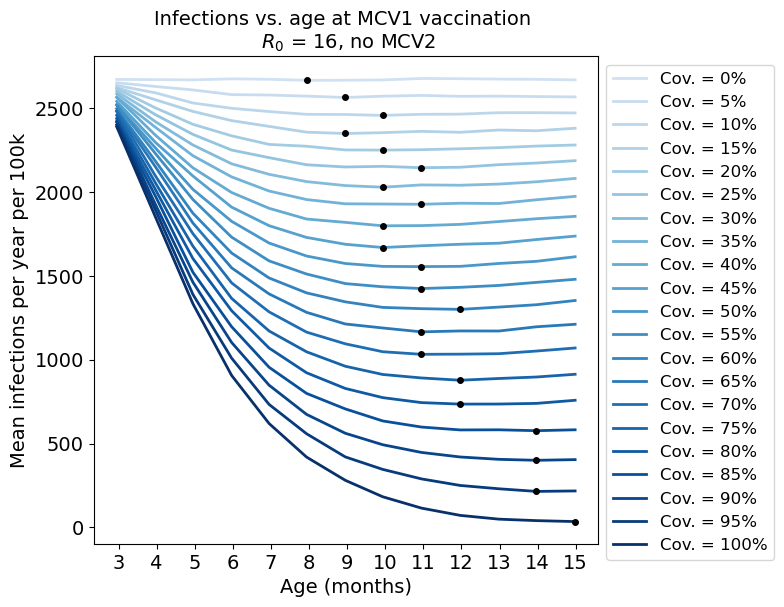

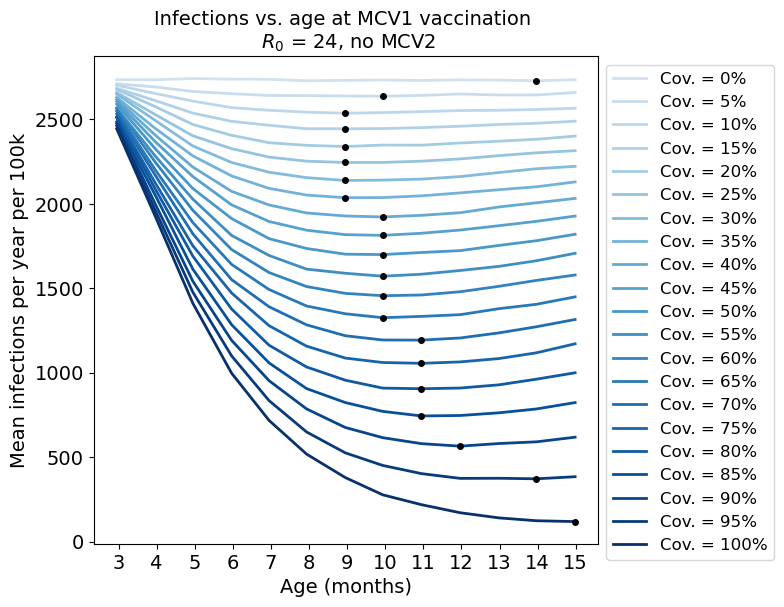

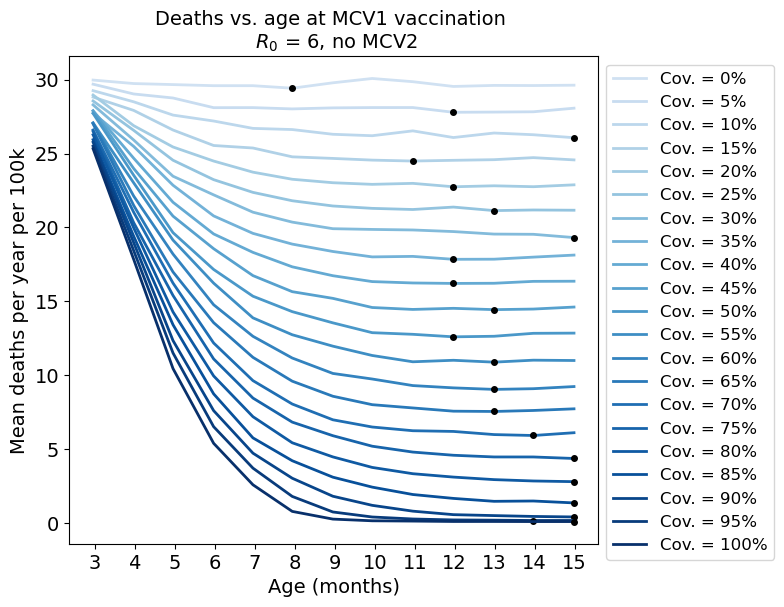

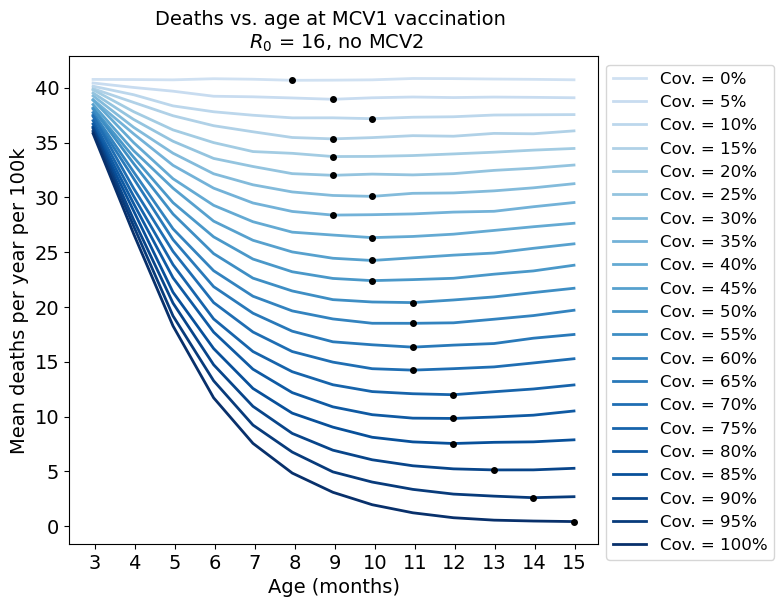

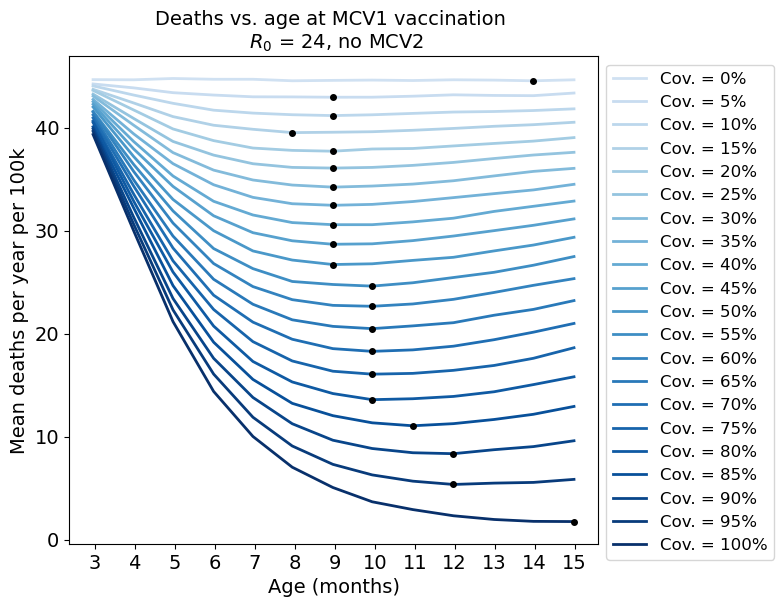

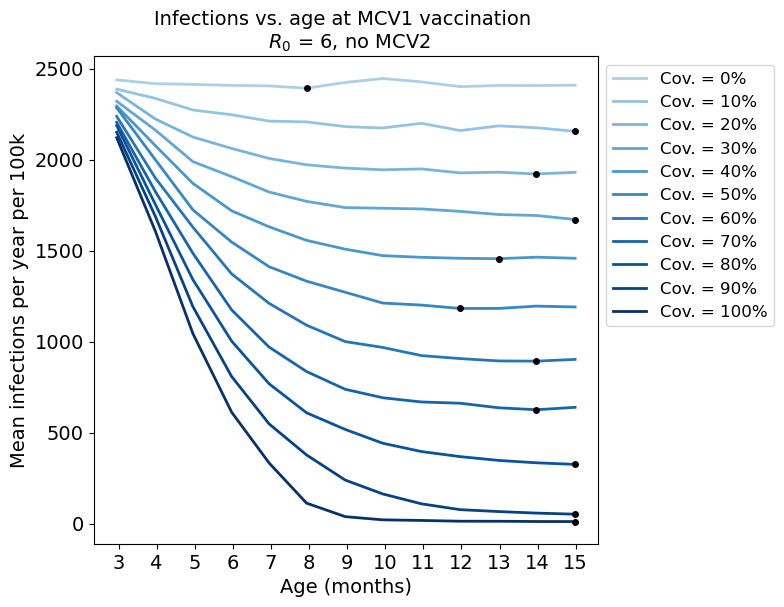

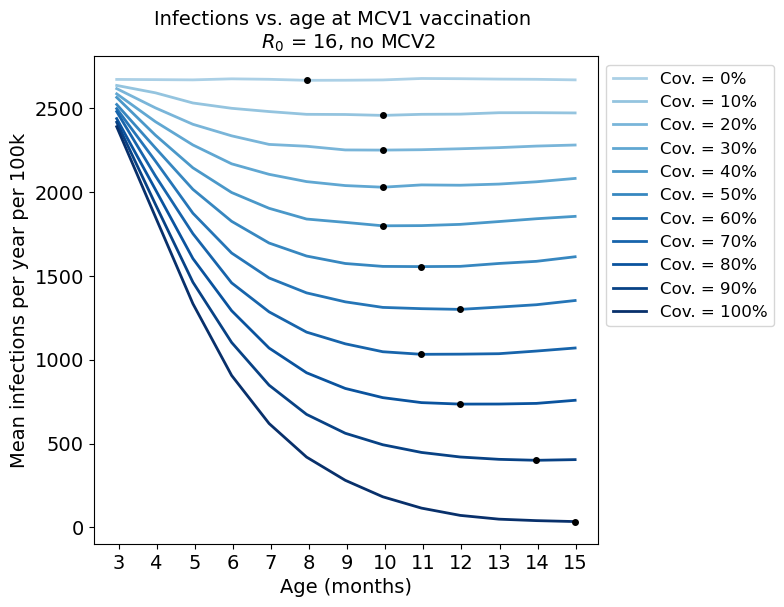

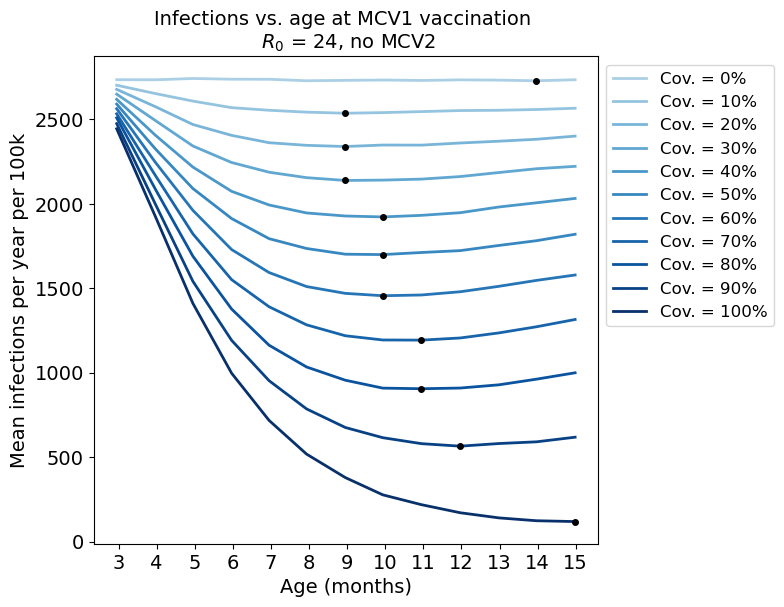

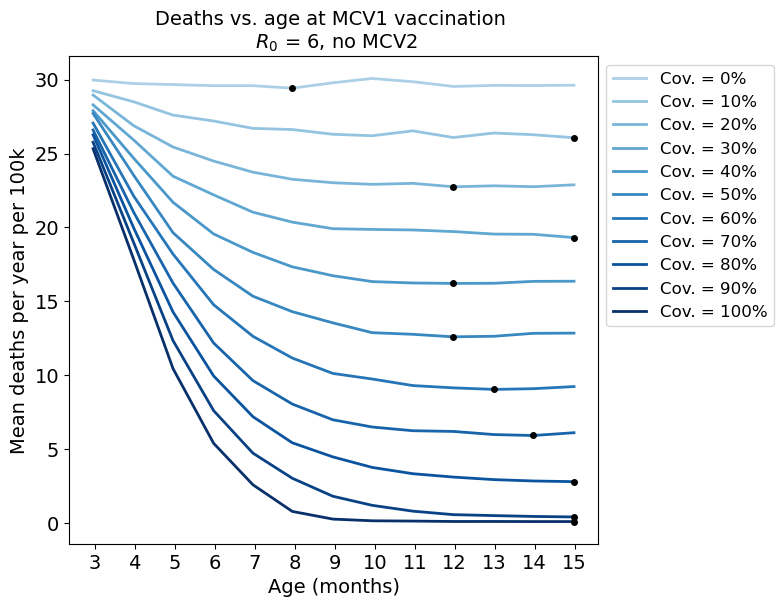

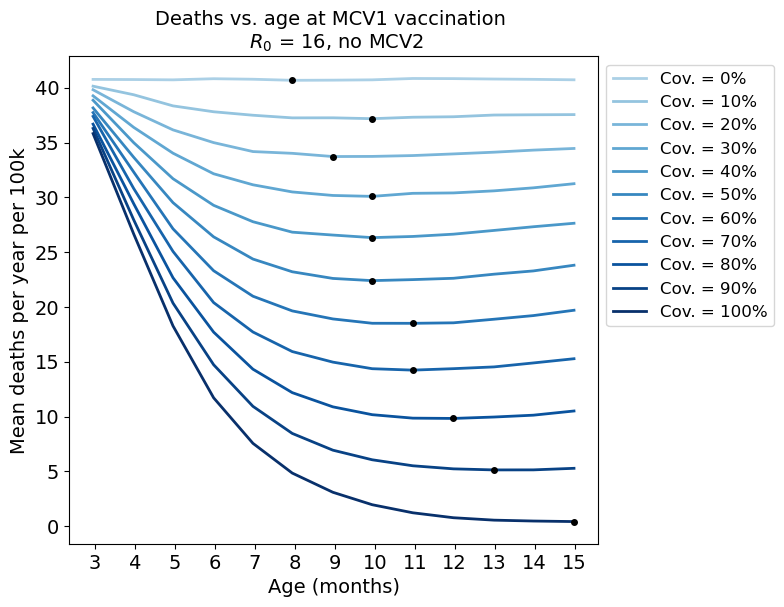

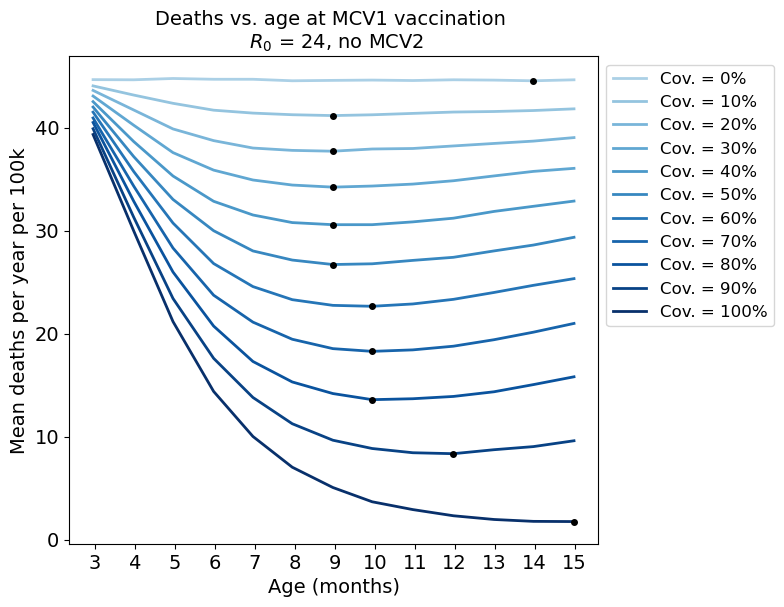

In [63]:
# Select rows where 'R0' is 16.0, all MCV1 values, no MCV2
base_cut = (grouped_df['mat_duration']==120.0) & \
(grouped_df['MCV2']<=0.1) & \
(grouped_df['mat_factor_inf']==1.0) & \
(grouped_df['mat_factor_vx']==0.4) & \
(grouped_df['MCV2_age']==1.25*365) & \
(grouped_df['start_year']==2040.0) & \
(grouped_df['timeliness_distribution'] == True) & \
(grouped_df['Ageind_vx_model']== False)

selected_rows = grouped_df[(grouped_df['R0'] == 6.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, np.unique(selected_rows['MCV1']))
ax.set_title('Infections vs. age at MCV1 vaccination \n $R_0$ = 6, no MCV2')

plt.show()

fig.savefig('MCV1only_AAV_R06.svg', format='svg', dpi=1000)

selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, np.unique(selected_rows['MCV1']))
ax.set_title('Infections vs. age at MCV1 vaccination \n $R_0$ = 16, no MCV2')

plt.show()

fig.savefig('MCV1only_AAV_R016.svg', format='svg', dpi=1000)

# Select rows where 'R0' is 16.0, all MCV1 values, no MCV2
selected_rows = grouped_df[(grouped_df['R0'] == 24.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, np.unique(selected_rows['MCV1']))
ax.set_title('Infections vs. age at MCV1 vaccination \n $R_0$ = 24, no MCV2')

plt.show()

fig.savefig('MCV1only_AAV_R024.svg', format='svg', dpi=1000)

selected_rows = grouped_df[(grouped_df['R0'] == 6.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, np.unique(selected_rows['MCV1']), var2plot='estimated_fatalities_nrm')
ax.set_ylabel('Mean deaths per year per 100k')
ax.set_title('Deaths vs. age at MCV1 vaccination \n $R_0$ = 6, no MCV2')

plt.show()

fig.savefig('MCV1only_AAV_R06_fatalities.svg', format='svg', dpi=1000)

selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, np.unique(selected_rows['MCV1']), var2plot='estimated_fatalities_nrm')
ax.set_ylabel('Mean deaths per year per 100k')
ax.set_title('Deaths vs. age at MCV1 vaccination \n $R_0$ = 16, no MCV2')

plt.show()

fig.savefig('MCV1only_AAV_R016_fatalities.svg', format='svg', dpi=1000)

# Select rows where 'R0' is 16.0, all MCV1 values, no MCV2
selected_rows = grouped_df[(grouped_df['R0'] == 24.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, np.unique(selected_rows['MCV1']), var2plot='estimated_fatalities_nrm')
ax.set_ylabel('Mean deaths per year per 100k')
ax.set_title('Deaths vs. age at MCV1 vaccination \n $R_0$ = 24, no MCV2')

plt.show()

fig.savefig('MCV1only_AAV_R024_fatalities.svg', format='svg', dpi=1000)


selected_rows = grouped_df[(grouped_df['R0'] == 6.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, np.unique(selected_rows['MCV1'])[::2])
ax.set_title('Infections vs. age at MCV1 vaccination \n $R_0$ = 6, no MCV2')

plt.show()

fig.savefig('MCV1only_AAV_R06_fewerlines.svg', format='svg', dpi=1000)

selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, np.unique(selected_rows['MCV1'])[::2])
ax.set_title('Infections vs. age at MCV1 vaccination \n $R_0$ = 16, no MCV2')

plt.show()

fig.savefig('MCV1only_AAV_R016_fewerlines.svg', format='svg', dpi=1000)

# Select rows where 'R0' is 16.0, all MCV1 values, no MCV2
selected_rows = grouped_df[(grouped_df['R0'] == 24.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, np.unique(selected_rows['MCV1'])[::2])
ax.set_title('Infections vs. age at MCV1 vaccination \n $R_0$ = 24, no MCV2')

plt.show()

fig.savefig('MCV1only_AAV_R024_fewerlines.svg', format='svg', dpi=1000)

selected_rows = grouped_df[(grouped_df['R0'] == 6.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, np.unique(selected_rows['MCV1'])[::2], var2plot='estimated_fatalities_nrm')
ax.set_ylabel('Mean deaths per year per 100k')
ax.set_title('Deaths vs. age at MCV1 vaccination \n $R_0$ = 6, no MCV2')

plt.show()

fig.savefig('MCV1only_AAV_R06_fatalities_fewerlines.svg', format='svg', dpi=1000)

selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, np.unique(selected_rows['MCV1'])[::2], var2plot='estimated_fatalities_nrm')
ax.set_ylabel('Mean deaths per year per 100k')
ax.set_title('Deaths vs. age at MCV1 vaccination \n $R_0$ = 16, no MCV2')

plt.show()

fig.savefig('MCV1only_AAV_R016_fatalities_fewerlines.svg', format='svg', dpi=1000)

# Select rows where 'R0' is 16.0, all MCV1 values, no MCV2
selected_rows = grouped_df[(grouped_df['R0'] == 24.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, np.unique(selected_rows['MCV1'])[::2], var2plot='estimated_fatalities_nrm')
ax.set_ylabel('Mean deaths per year per 100k')
ax.set_title('Deaths vs. age at MCV1 vaccination \n $R_0$ = 24, no MCV2')

plt.show()

fig.savefig('MCV1only_AAV_R024_fatalities_fewerlines.svg', format='svg', dpi=1000)

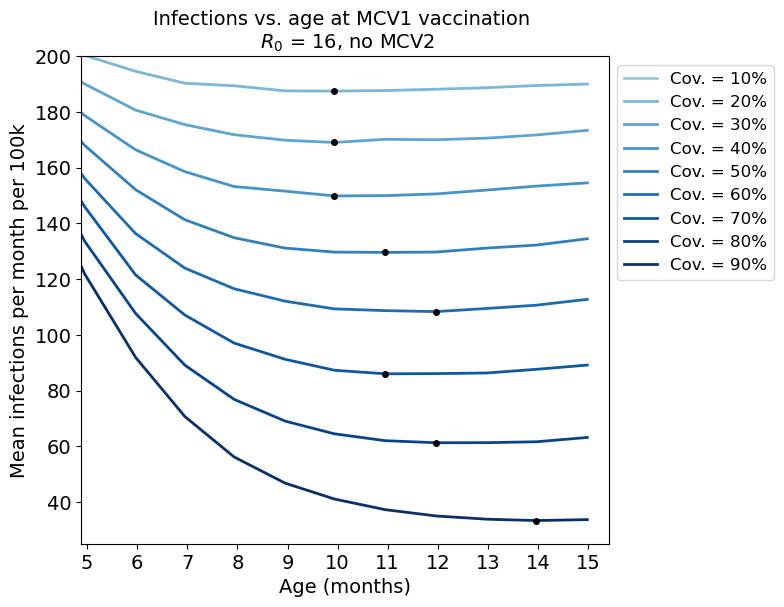

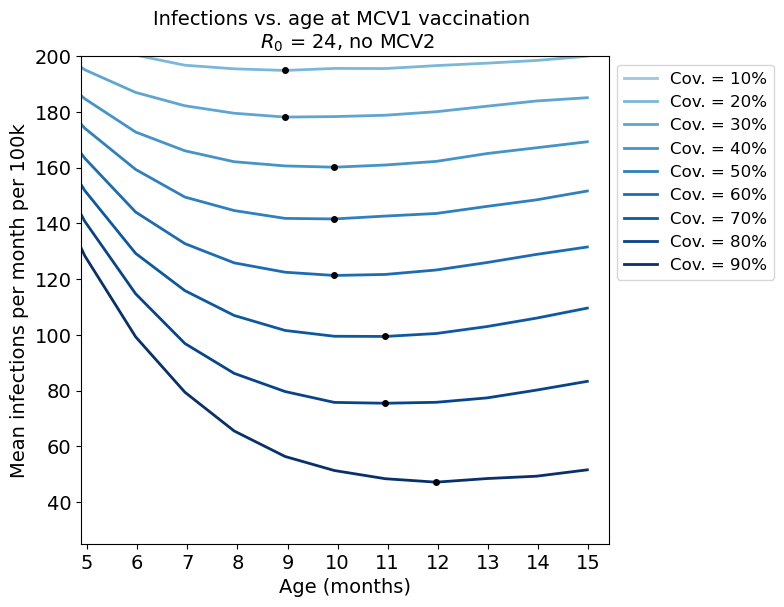

In [387]:
selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, [i/10 for i in range(1, 10)])
fig.savefig('MCV1only_AAV_R016_fewer_lines.svg', format='svg', dpi=1000)
ax.set_xlim([149, 470])
ax.set_ylim([25, 200])
ax.set_title('Infections vs. age at MCV1 vaccination \n $R_0$ = 16, no MCV2')
fig.savefig('MCV1only_AAV_R016_zoom.svg', format='svg', dpi=1000)

selected_rows = grouped_df[(grouped_df['R0'] == 24.0) & base_cut]
(fig, ax) = line_plot_age(selected_rows, [i/10 for i in range(1, 10)])
fig.savefig('MCV1only_AAV_R024_fewer_lines.svg', format='svg', dpi=1000)
ax.set_xlim([149, 470])
ax.set_ylim([25, 200])
ax.set_title('Infections vs. age at MCV1 vaccination \n $R_0$ = 24, no MCV2')
fig.savefig('MCV1only_AAV_R024_zoom.svg', format='svg', dpi=1000)

/var/folders/1b/yq6gx3hj51jf_v98kwv057xh0000gn/T/ipykernel_8686/2028513274.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  contour = plt.contour(X, Y, 1-Z/np.max(np.max(Z)), cmap='viridis_r', levels=[i/10 for i in range(1, 10)], label='Infections')#, levels=[20*i for i in range(11)])  # 'cividis' is colorblind-friendly
/var/folders/1b/yq6gx3hj51jf_v98kwv057xh0000gn/T/ipykernel_8686/2028513274.py:51: UserWarning: The following kwargs were not used by contour: 'label'
  contour = plt.contour(X, Y, 1-Z/np.max(np.max(Z)), linestyles='dashed', cmap='viridis_r', label='Deaths', levels=[i/10 for i in range(1, 10)])#, levels=[20*i for i in range(11)])  # 'cividis' is colorblind-friendly


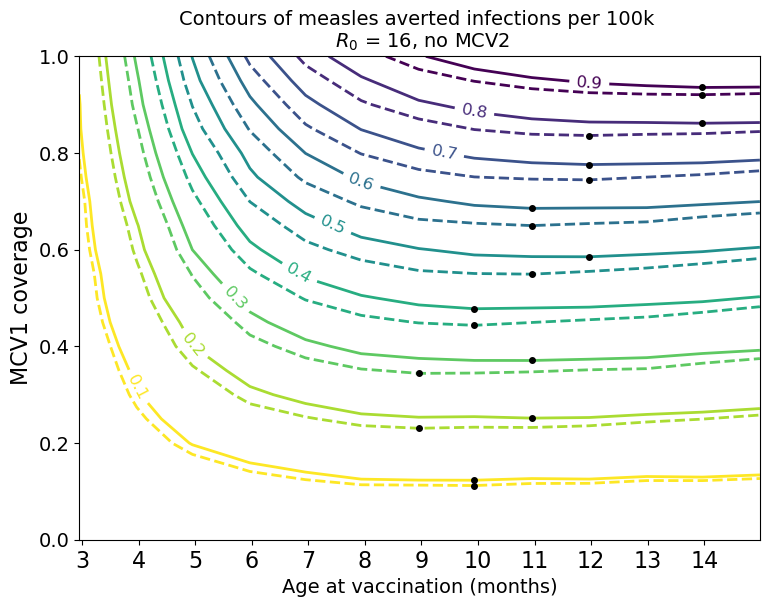

In [89]:
def infection_contours(selected_rows, var2plot='Inf_mean_nrm'):
    fig, ax = plt.subplots(figsize = (8, 6))

    pivot_df = selected_rows.pivot_table(index='MCV1', columns='MCV1_age', values=var2plot)

    # Prepare the grid for contour plot
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values

    # Generate a contour plot
    #plt.figure(figsize=(8, 6))
    contour = plt.contour(X, Y, 1-Z/np.max(np.max(Z)), cmap='viridis_r', levels=[i/10 for i in range(1, 10)], label='Infections')#, levels=[20*i for i in range(11)])  # 'cividis' is colorblind-friendly
    plt.clabel(contour)

    for i, segs in enumerate(contour.allsegs):
        for seg in segs:
            # Find the point with minimum y-value and its corresponding x-value
            min_y_index = np.argmin(seg[:, 1])
            min_y_point = seg[min_y_index]
            x_min, y_min = min_y_point

            # Plot the point with a red 'x'
            plt.plot(x_min, y_min, 'k.')
    #plt.colorbar(contour)  # Add a colorbar to a plot

    # Set the labels and title

    # Set the title and labels
    ax.set_title('Contours of measles infections averted (per year per 100k)')
    ax.set_xlabel('Age at vaccination (months)')
    ax.set_ylabel('MCV1 coverage', fontsize = 16)
    ax.set_xticks([30.5*i for i in range(3, 16)])
    ax.set_xticklabels([str(i) for i in range(3, 16)], fontsize=16)
    # Show legend
    #ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    return (fig, ax)

selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & base_cut]
(fig, ax) = infection_contours(selected_rows)
ax.set_title('Contours of measles averted infections per 100k \n $R_0$ = 16, no MCV2')

fig.savefig('MCV1only_contours_R016.svg', format='svg', dpi=1000)

pivot_df = selected_rows.pivot_table(index='MCV1', columns='MCV1_age', values='estimated_fatalities_nrm')

# Prepare the grid for contour plot
X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
Z = pivot_df.values
contour = plt.contour(X, Y, 1-Z/np.max(np.max(Z)), linestyles='dashed', cmap='viridis_r', label='Deaths', levels=[i/10 for i in range(1, 10)])#, levels=[20*i for i in range(11)])  # 'cividis' is colorblind-friendly
for i, segs in enumerate(contour.allsegs):
    for seg in segs:
        # Find the point with minimum y-value and its corresponding x-value
        min_y_index = np.argmin(seg[:, 1])
        min_y_point = seg[min_y_index]
        x_min, y_min = min_y_point

        # Plot the point with a red 'x'
        plt.plot(x_min, y_min, 'k.')
    #plt.colorbar(contour)  # Add a colorb
fig.savefig('MCV1_inf_death_contours_samefig.svg', format='svg')
#selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & base_cut]
#(fig, ax) = infection_contours(selected_rows, var2plot='estimated_fatalities_nrm')
#ax.set_title('Contours of measles deaths averted infections per 100k \n $R_0$ = 16, no MCV2')

#fig.savefig('MCV1only_contours_R016_fatalities.svg', format='svg', dpi=1000)

#selected_rows = grouped_df[(grouped_df['R0'] == 24.0) & base_cut]
#(fig, ax) = infection_contours(selected_rows)
#ax.set_title('Contours of measles averted infections per 100k \n $R_0$ = 24, no MCV2')

#fig.savefig('MCV1only_contours_R024.svg', format='svg', dpi=1000)


<Figure size 640x480 with 0 Axes>

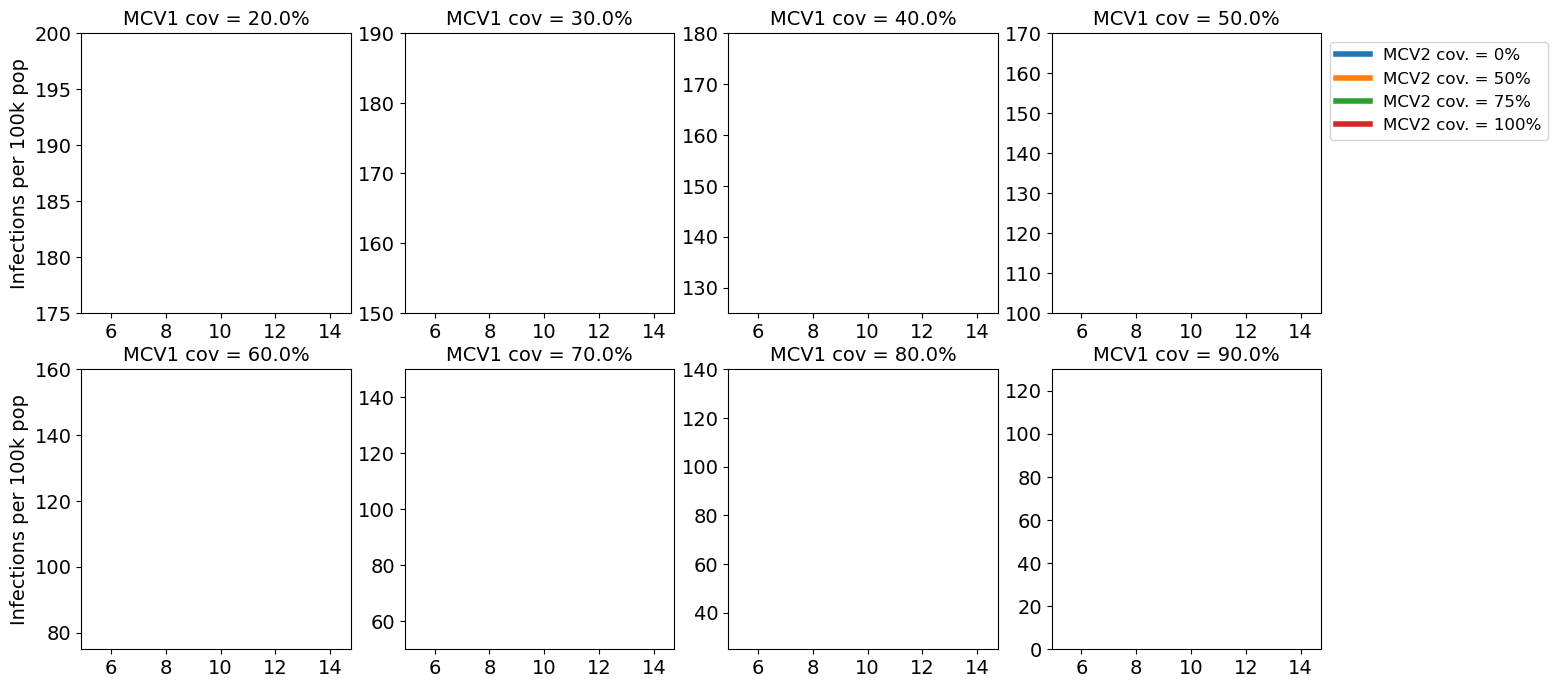

Bad pipe message: %s [b'\xe2\xa6w\x11\xd5\x7f\xbe\xe1ln+\xf0\x87\x1d\x16\xc8\x0e\x97\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00']
Bad pipe message: %s [b"\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\

Bad pipe message: %s [b"\xc5\xe3Q\x88\xc0\x9aZ\x18JY\xb9\xb4\x8b\xd0=\x96Pv\x00\x00D\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\xc0#\xc0$\xc0%\xc0&\xc0'\xc0(\xc0)\xc0*\xc0+\xc0,\xc0-\xc0.\xc0/\xc00\xc01\xc02", b'\x01']
Bad pipe message: %s [b"c\xa7\xec\x01\x85'\x89\xae8\xa3MB\x19\xba\xd1w@\xc3\x00\x00T\xc0r\xc0s\xc0t\xc0u\xc0v\xc0w\xc0x\xc0y\xc0z\xc0{\xc0|\xc0}\xc0~\xc0\x7f\xc0\x80\xc0\x81\xc0\x82\xc0\x83\xc0\x84\xc0\x85\xc0\x86\xc0\x87\xc0\x88\xc0\x89\xc0\x8a\xc0\x8b\xc0\x8c\xc0\x8d\xc0\x8e\xc0\x8f\xc0\x90\xc0\x91\xc0\x92\xc0\x93\xc0\x94\xc0\x95\xc0\x96\xc0\x97\xc0\x98\xc0\x99\xc0"]
Bad pipe message: %s [b't\xe6\xe7\xed\xef\x00[D)\xe6\x1e', b'\xd0\x95\x16$X\x00\x00*\x00\x03\x00\x06\x00\x07\x00\x08\x00\t\x00\x0b\x00', b'\x0e\x00\x0f\x00\x11\x00\x12\x00\x14\x00\x15']
Bad pipe message: %s [b'\xac\xdc\xc8`\x9cS$Y\x9f\x10\xfe\xb5]$6\x01\xec\\\x00\x006\xc0\x01\xc0\x03\xc0\x04\xc0\x05\xc0\x06

Bad pipe message: %s [b'\x84tx\xbf\xae\xda\x8e,L\xd9y[\xbe2#\xb9\xa8\xea\x00\x00T\xc0r\xc0s\xc0t\xc0u\xc0v\xc0w\xc0x\xc0y\xc0z\xc0{\xc0|\xc0}\xc0~\xc0\x7f\xc0\x80\xc0\x81\xc0\x82\xc0\x83\xc0\x84\xc0\x85\xc0\x86\xc0\x87\xc0\x88\xc0\x89\xc0\x8a\xc0\x8b\xc0']
Bad pipe message: %s [b'\xc7Ber\x9f\xcf\xedW\x1aL\xc2-4O5\xf4\x06"\x00\x000\x00A\x00B\x00']
Bad pipe message: %s [b'\x99\x19\x95\x81\x8f\xa4v\xb7z\xa8\xa3$\xd5y\xd7\x94K\xa0\x00\x00T\xc0r\xc0s\xc0t\xc0u\xc0v\xc0w\xc0x\xc0y\xc0z\xc0{\xc0|\xc0}\xc0~\xc0\x7f\xc0\x80\xc0']
Bad pipe message: %s [b"\x84{jwT\xdd\xdc+ND\xadJ\x85x&F)0\x00\x00D\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\xc0#\xc0$\xc0%\xc0&\xc0'\xc0(\xc0)\xc0*\xc0+\xc0,\xc0-\xc0.\xc0/\xc00\xc01\xc02\x02\x00\x01\x00,\x00\n\x00\n\x00\x08\x00\x17\x00\x19\x00\x18\x00\x16\x00\x0b\x00\x04\x03\x00\x01\x02\x00\r\x00\x12\x00\x10\x04\x03\x08", b'\x01\x05\x03']
Bad pipe message: %s [b'\xa7

In [97]:

def MCV2_plots(selected_rows, var2plot='Inf_mean_nrm'):

    # Plotting
    fig, axs = plt.subplots(2, 4, figsize = (16, 8))

    # Get unique values of 'MCV1' to plot separate lines
    i = -1
    for mcv1_value in [.2, .3, .4, .5, .6, .7, .8, .9]:
        subset1 = selected_rows[selected_rows['MCV1'] == mcv1_value].reset_index()
        i = i+1
        ax = axs[int(np.floor(i/4)), i%4]

        for MCV2 in [0.0, 0.5, 0.75, 1.0]:
            # Filter rows for each MCV1 value
            subset = subset1[subset1['MCV2'] == MCV2].reset_index()

            # Sort rows by 'MCV1_age' to get a proper line plot
            subset = subset.sort_values('MCV1_age')

            # Plot 'Infs' vs. 'MCV1_age' for the current MCV1 value
            ax.plot(subset['MCV1_age'], subset[var2plot], label=f'MCV2 cov. = {int(100*MCV2)}%', linewidth=4)
            yv = np.min(subset[var2plot])
            xv = np.argmin(subset[var2plot])
            ax.plot(subset['MCV1_age'][xv], yv, 'k.', markersize=12)
            ax.set_xticks([30.5*i for i in range(4, 16, 2)])
            ax.set_xticklabels([str(i) for i in range(4, 16, 2)])
        ax.set_title('MCV1 cov = '+str(100*mcv1_value)+'%')
        if i == 3:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        if i%4==0:
            ax.set_ylabel('Infections per 100k pop')

    return (fig, axs)

# Show legend
#ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
# Show plot
plt.show()


new_cut = (grouped_df['mat_duration']==120.0) & \
(grouped_df['MCV2_age']==1.25*365) & \
(grouped_df['mat_factor_inf']==1.0) & \
(grouped_df['mat_factor_vx']==0.4) & \
(grouped_df['start_year']==2040.0) & \
(grouped_df['timeliness_distribution'] == True) & \
(grouped_df['Ageind_vx_model']== False)

selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & new_cut]
(fig, axs) = MCV2_plots(selected_rows)

fig.savefig('MCV2_curves_R016.svg', format='svg', dpi=1000, bbox_inches='tight')

for i in range(8):
    axs[int(np.floor(i/4)), i%4].set_xlim(150, 450)
    axs[int(np.floor(i/4)), i%4].set_ylim((7-i)*25, 100+(10-i)*10)
plt.show()
fig.savefig('MCV2_curves_R016_zoomed.svg', format='svg', dpi=1000, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

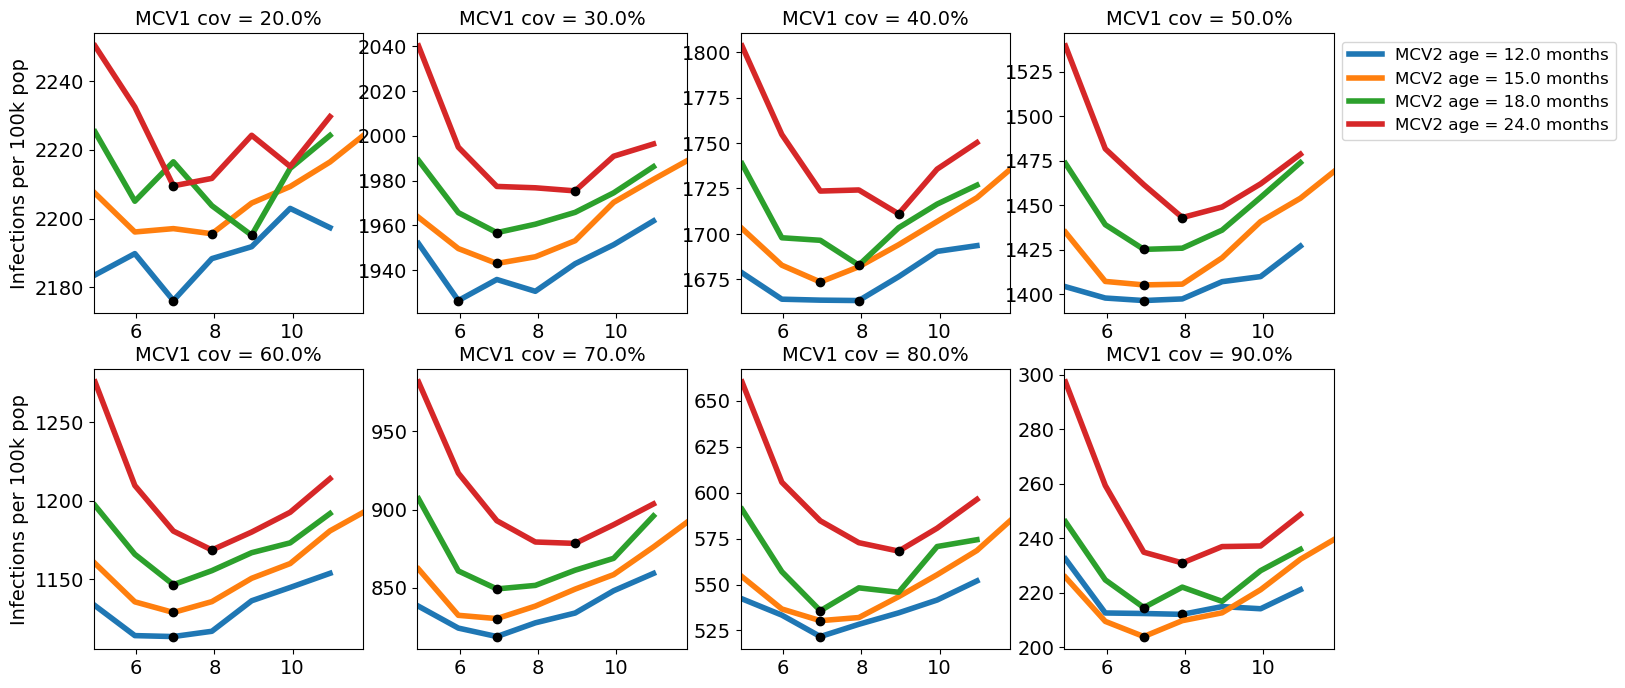

In [95]:

def MCV2Age_plots(selected_rows, var2plot='Inf_mean_nrm'):

    # Plotting
    fig, axs = plt.subplots(2, 4, figsize = (16, 8))

    # Get unique values of 'MCV1' to plot separate lines
    i = -1
    for mcv1_value in [.2, .3, .4, .5, .6, .7, .8, .9]:
        subset1 = selected_rows[selected_rows['MCV1'] == mcv1_value].reset_index()
        i = i+1
        ax = axs[int(np.floor(i/4)), i%4]

        for MCV2Age in np.unique(subset1['MCV2_age']):
            # Filter rows for each MCV1 value
            subset = subset1[subset1['MCV2_age'] == MCV2Age].reset_index()

            # Sort rows by 'MCV1_age' to get a proper line plot
            subset = subset.sort_values('MCV1_age')

            # Plot 'Infs' vs. 'MCV1_age' for the current MCV1 value
            ax.plot(subset['MCV1_age'][2:], subset[var2plot][2:], label=f'MCV2 age = {np.round(MCV2Age/30)} months', linewidth=4)
            yv = np.min(subset[var2plot])
            xv = np.argmin(subset[var2plot])
            ax.plot(subset['MCV1_age'][xv], yv, 'k.', markersize=12)
            ax.set_xticks([30.5*i for i in range(4, 12, 2)])
            ax.set_xticklabels([str(i) for i in range(4, 12, 2)])
            ax.set_xlim([150, 360])
        ax.set_title('MCV1 cov = '+str(100*mcv1_value)+'%')
        if i == 3:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        if i%4==0:
            ax.set_ylabel('Infections per 100k pop')
    
    return (fig, axs)

# Show legend
#ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
# Show plot
plt.show()


new_cut = (grouped_df['mat_duration']==120.0) & \
(grouped_df['MCV2']==1.0) & \
(grouped_df['mat_factor_inf']==1.0) & \
(grouped_df['mat_factor_vx']==0.4) & \
(grouped_df['start_year']==2040.0) & \
(grouped_df['timeliness_distribution'] == True) & \
(grouped_df['Ageind_vx_model']== False)

selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & new_cut]
(fig, axs) = MCV2Age_plots(selected_rows)

fig.savefig('MCV2Age_curves_R016.svg', format='svg', dpi=1000)

#for i in range(8):
#    axs[int(np.floor(i/4)), i%4].set_xlim(150, 360)
#   axs[int(np.floor(i/4)), i%4].set_ylim((7-i)*25, 100+(10-i)*10)
#plt.show()
#fig.savefig('MCV2Age_curves_R016_zoomed.svg', format='svg', dpi=1000)


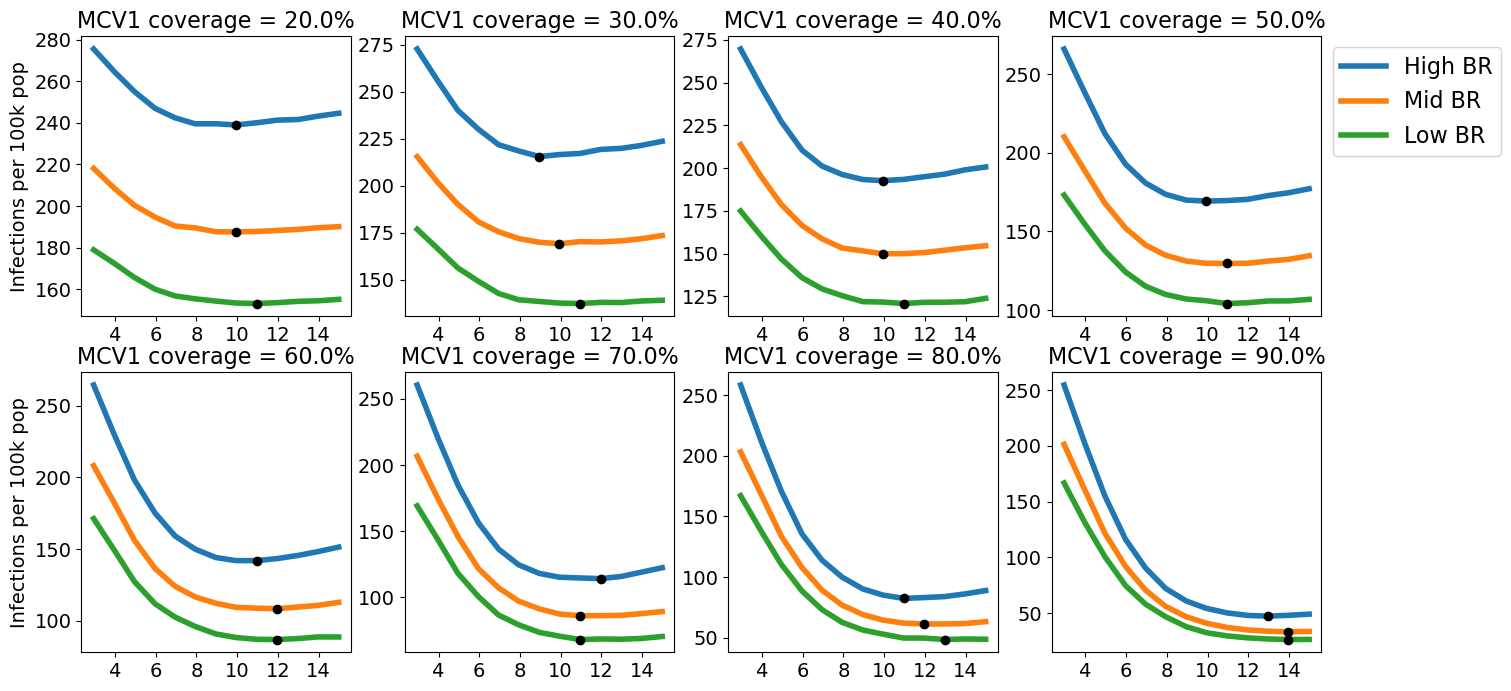

In [403]:
def demographic_plots(selected_rows, var2plot='Inf_mean_nrm'):

    # Plotting
    fig, axs = plt.subplots(2, 4, figsize = (16, 8))

    # Get unique values of 'MCV1' to plot separate lines
    i = -1
    for mcv1_value in [.2, .3, .4, .5, .6, .7, .8, .9]:
        subset1 = selected_rows[selected_rows['MCV1'] == mcv1_value].reset_index()
        i = i+1
        ax = axs[int(np.floor(i/4)), i%4]
        j = -1
        for start_year in [2020, 2040, 2060]:
            j = j+1
            demographics = ['High BR', 'Mid BR', 'Low BR']
            # Filter rows for each MCV1 value
            subset = subset1[subset1['start_year'] == start_year].reset_index()

            # Sort rows by 'MCV1_age' to get a proper line plot
            subset = subset.sort_values('MCV1_age')

            # Plot 'Infs' vs. 'MCV1_age' for the current MCV1 value
            ax.plot(subset['MCV1_age'], subset[var2plot], label=demographics[j], linewidth=4)
            yv = np.min(subset[var2plot])
            xv = np.argmin(subset[var2plot])
            ax.plot(subset['MCV1_age'][xv], yv, 'k.', markersize=12)
            ax.set_xticks([30.5*i for i in range(4, 16, 2)])
            ax.set_xticklabels([str(i) for i in range(4, 16, 2)], fontsize=14)
        ax.set_title('MCV1 coverage = '+str(100*mcv1_value)+'%', fontsize=16)
        if i == 3:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 16)
        if i%4==0:
            ax.set_ylabel('Infections per 100k pop', fontsize = 14)
        ax.tick_params(axis='y', which='major', labelsize=14)
    return (fig, axs)

new_cut = (grouped_df['mat_duration']==120.0) & \
(grouped_df['MCV2_age']==1.25*365) & \
(grouped_df['mat_factor_inf']==1.0) & \
(grouped_df['mat_factor_vx']==0.4) & \
(grouped_df['MCV2']==0.0) & \
(grouped_df['timeliness_distribution'] == True) & \
(grouped_df['Ageind_vx_model']== False)

selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & new_cut]
(fig, axs) = demographic_plots(selected_rows)
fig.savefig('MCV1_curves_demographics.svg', format='svg', dpi=1000)


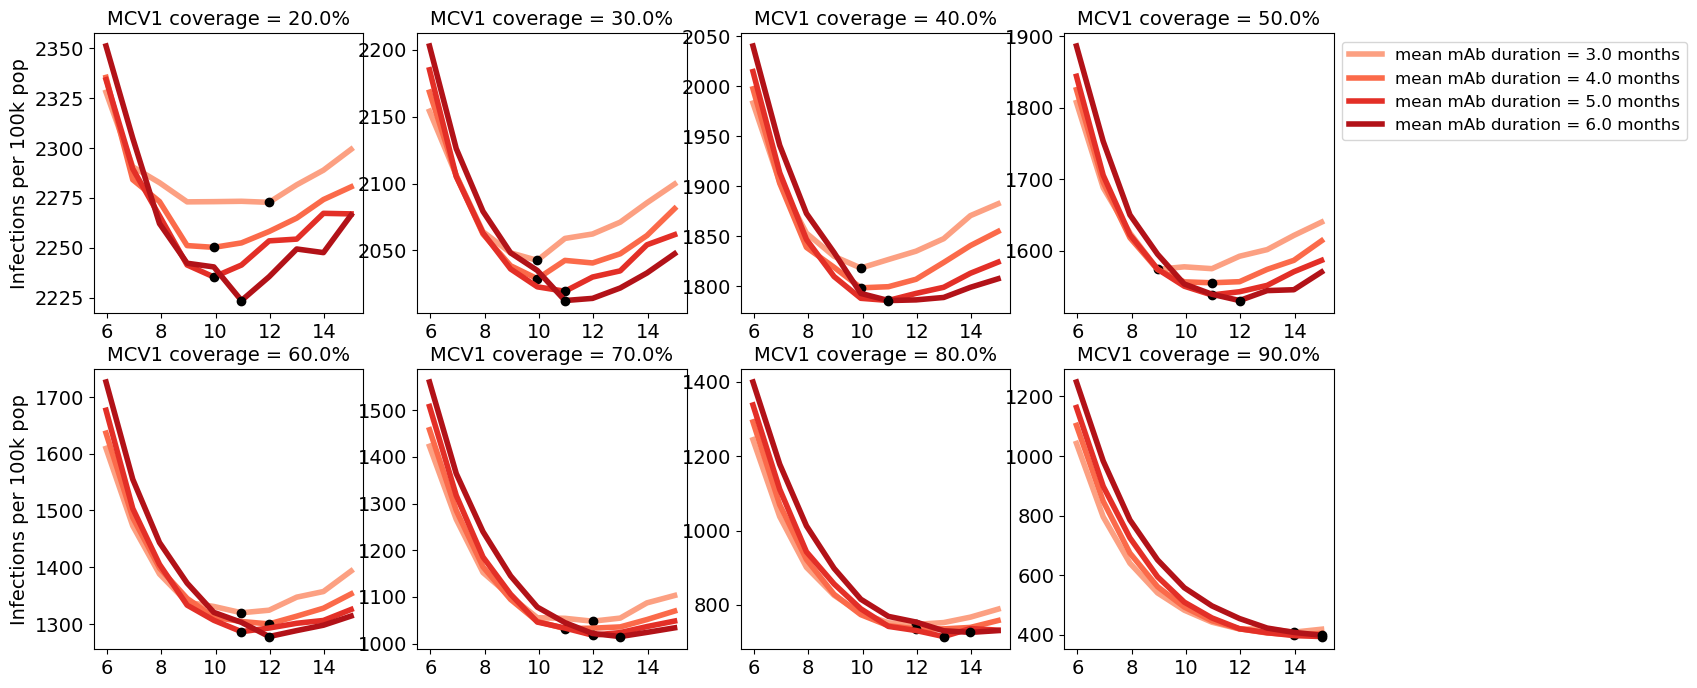

In [93]:
def mAb_duration_plots(selected_rows, var2plot='Inf_mean_nrm'):

    # Plotting
    fig, axs = plt.subplots(2, 4, figsize = (16, 8))

    # Get unique values of 'MCV1' to plot separate lines
    i = -1
    for mcv1_value in [.2, .3, .4, .5, .6, .7, .8, .9]:
        subset1 = selected_rows[selected_rows['MCV1'] == mcv1_value].reset_index()
        i = i+1
        ax = axs[int(np.floor(i/4)), i%4]
        mycmap2 = plt.get_cmap('Reds', 7)
        j=1
        for mAb_duration in [90, 120, 150, 180]:
            # Filter rows for each MCV1 value
            j=j+1
            subset = subset1[subset1['mat_duration'] == mAb_duration].reset_index()

            # Sort rows by 'MCV1_age' to get a proper line plot
            subset = subset.sort_values('MCV1_age')

            # Plot 'Infs' vs. 'MCV1_age' for the current MCV1 value
            ax.plot(subset['MCV1_age'][3:], subset[var2plot][3:], label=f'mean mAb duration = {mAb_duration/30} months', linewidth=4, color=mycmap2(j))
            yv = np.min(subset[var2plot])
            xv = np.argmin(subset[var2plot])
            ax.plot(subset['MCV1_age'][xv], yv, 'k.', markersize=12)
            ax.set_xticks([30.5*i for i in range(6, 16, 2)])
            ax.set_xticklabels([str(i) for i in range(6, 16, 2)])
        ax.set_title('MCV1 coverage = '+str(100*mcv1_value)+'%')
        if i == 3:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        if i%4==0:
            ax.set_ylabel('Infections per 100k pop', fontsize = 14)
        ax.tick_params(axis='y', which='major', labelsize=14)
    return (fig, axs)

new_cut = (grouped_df['mat_factor_inf']==1.0) & \
(grouped_df['mat_factor_vx']==0.4) & \
(grouped_df['MCV2_age']==1.25*365) & \
(grouped_df['start_year']==2040) & \
(grouped_df['MCV2']==0.0) & \
(grouped_df['timeliness_distribution'] == True) & \
(grouped_df['Ageind_vx_model']== False)

selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & new_cut]
(fig, axs) = mAb_duration_plots(selected_rows)
fig.savefig('MCV1_curves_durations.svg', format='svg', dpi=1000, bbox_inches='tight')


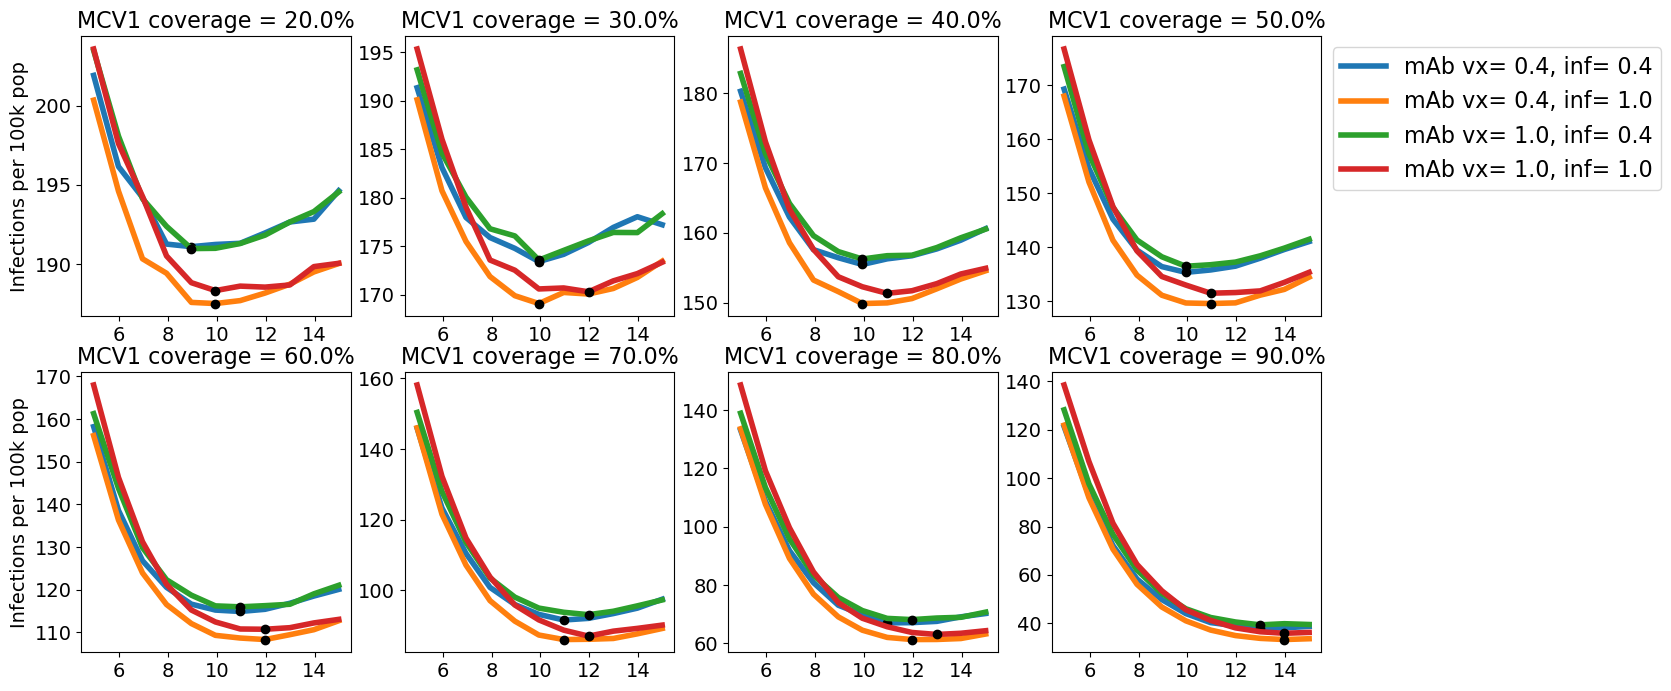

In [406]:
def mAb_effect_plots(selected_rows, var2plot='Inf_mean_nrm'):

    # Plotting
    fig, axs = plt.subplots(2, 4, figsize = (16, 8))

    # Get unique values of 'MCV1' to plot separate lines
    i = -1
    for mcv1_value in [.2, .3, .4, .5, .6, .7, .8, .9]:
        subset1 = selected_rows[selected_rows['MCV1'] == mcv1_value].reset_index()
        i = i+1
        ax = axs[int(np.floor(i/4)), i%4]
        for mAb_effect_vx in np.unique(subset1['mat_factor_vx']):
            for mAb_effect_inf in np.unique(subset1['mat_factor_inf']):
            # Filter rows for each MCV1 value
                subset = subset1[(subset1['mat_factor_vx'] == mAb_effect_vx) &\
                                 (subset1['mat_factor_inf'] == mAb_effect_inf)].reset_index()

                # Sort rows by 'MCV1_age' to get a proper line plot
                subset = subset.sort_values('MCV1_age')

                # Plot 'Infs' vs. 'MCV1_age' for the current MCV1 value
                ax.plot(subset['MCV1_age'][2:], subset[var2plot][2:], label='mAb vx= '+str(mAb_effect_vx)+', inf= '+str(mAb_effect_inf), linewidth=4)
                yv = np.min(subset[var2plot])
                xv = np.argmin(subset[var2plot])
                ax.plot(subset['MCV1_age'][xv], yv, 'k.', markersize=12)
                ax.set_xticks([30.5*i for i in range(6, 16, 2)])
                ax.set_xticklabels([str(i) for i in range(6, 16, 2)], fontsize=14)
        ax.set_title('MCV1 coverage = '+str(100*mcv1_value)+'%', fontsize=16)
        if i == 3:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 16)
        if i%4==0:
            ax.set_ylabel('Infections per 100k pop', fontsize = 14)
        ax.tick_params(axis='y', which='major', labelsize=14)
    return (fig, axs)



new_cut = (grouped_df['mat_duration']==120.0) & \
(grouped_df['start_year']==2040) & \
(grouped_df['MCV2_age']==1.25*365) & \
(grouped_df['MCV2']==0.0) & \
(grouped_df['timeliness_distribution'] == True) & \
(grouped_df['Ageind_vx_model']== False)

selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & new_cut]
(fig, axs) = mAb_effect_plots(selected_rows)
fig.savefig('MCV1_curves_effects.svg', format='svg', dpi=1000)


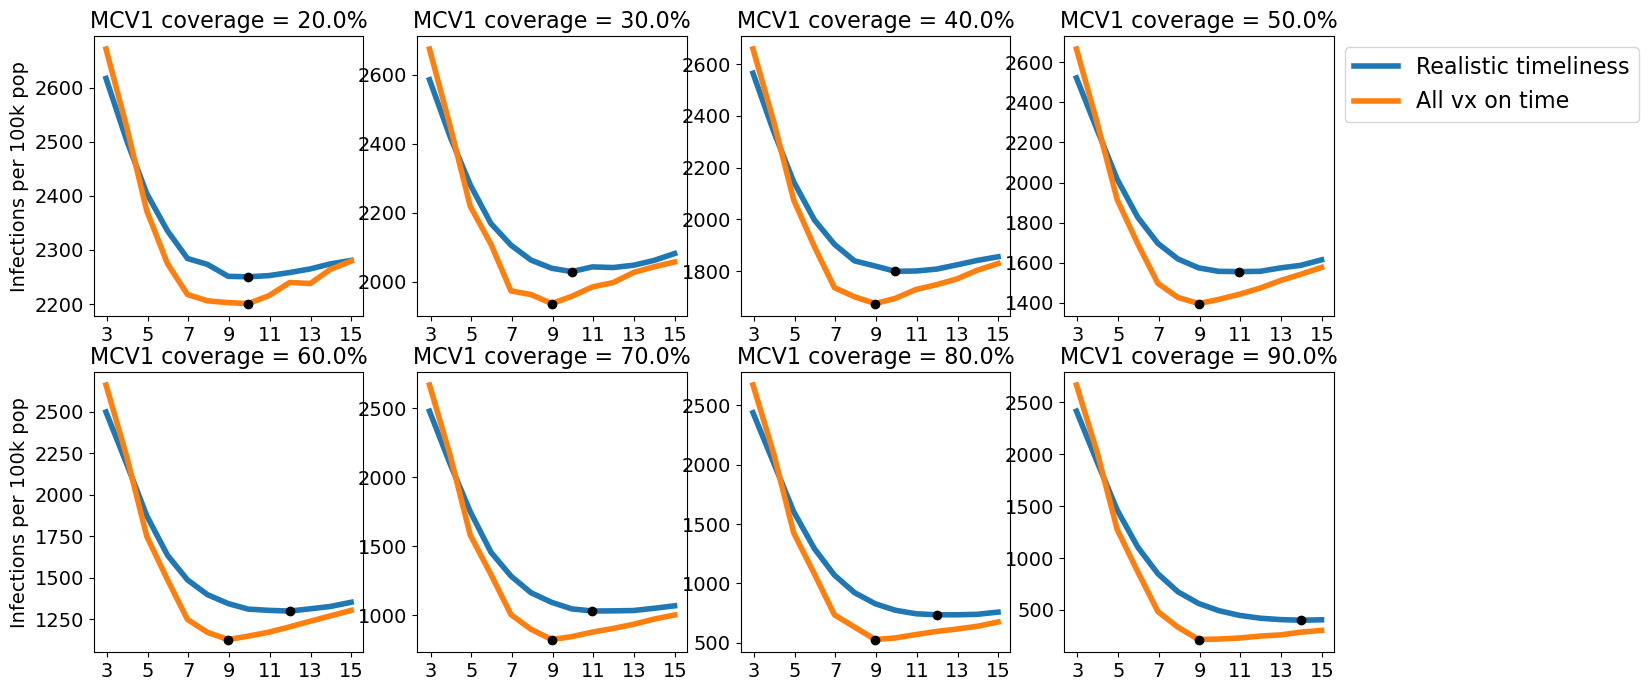

In [90]:
def vx_timeliness_plots(selected_rows, var2plot='Inf_mean_nrm'):

    # Plotting
    fig, axs = plt.subplots(2, 4, figsize = (16, 8))

    # Get unique values of 'MCV1' to plot separate lines
    i = -1
    for mcv1_value in [.2, .3, .4, .5, .6, .7, .8, .9]:
        subset1 = selected_rows[selected_rows['MCV1'] == mcv1_value].reset_index()
        i = i+1
        ax = axs[int(np.floor(i/4)), i%4]
        for flag in [True, False]:
            # Filter rows for each MCV1 value
                subset = subset1[(subset1['timeliness_distribution'] == flag)].reset_index()
                # Sort rows by 'MCV1_age' to get a proper line plot
                subset = subset.sort_values('MCV1_age')
                if flag: 
                    mylabel = 'Realistic timeliness'
                else:
                    mylabel = 'All vx on time'
                # Plot 'Infs' vs. 'MCV1_age' for the current MCV1 value
                ax.plot(subset['MCV1_age'], subset[var2plot], label=mylabel, linewidth=4)
                yv = np.min(subset[var2plot])
                xv = np.argmin(subset[var2plot])
                ax.plot(subset['MCV1_age'][xv], yv, 'k.', markersize=12)
                ax.set_xticks([30.5*i for i in range(3, 16, 2)])
                ax.set_xticklabels([str(i) for i in range(3, 16, 2)], fontsize=14)
        ax.set_title('MCV1 coverage = '+str(100*mcv1_value)+'%', fontsize=16)
        if i == 3:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 16)
        if i%4==0:
            ax.set_ylabel('Infections per 100k pop', fontsize = 14)
        ax.tick_params(axis='y', which='major', labelsize=14)
    return (fig, axs)

new_cut = (grouped_df['mat_duration']==120.0) & \
(grouped_df['start_year']==2040) & \
(grouped_df['mat_factor_inf']==1.0) & \
(grouped_df['mat_factor_vx']==0.4) & \
(grouped_df['MCV2_age']==1.25*365) & \
(grouped_df['MCV2']==0.0) & \
(grouped_df['Ageind_vx_model']== False)


selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & new_cut]
(fig, axs) = vx_timeliness_plots(selected_rows)
fig.savefig('MCV1_curves_vx_timeliness.svg', format='svg', dpi=1000, bbox_inches='tight')


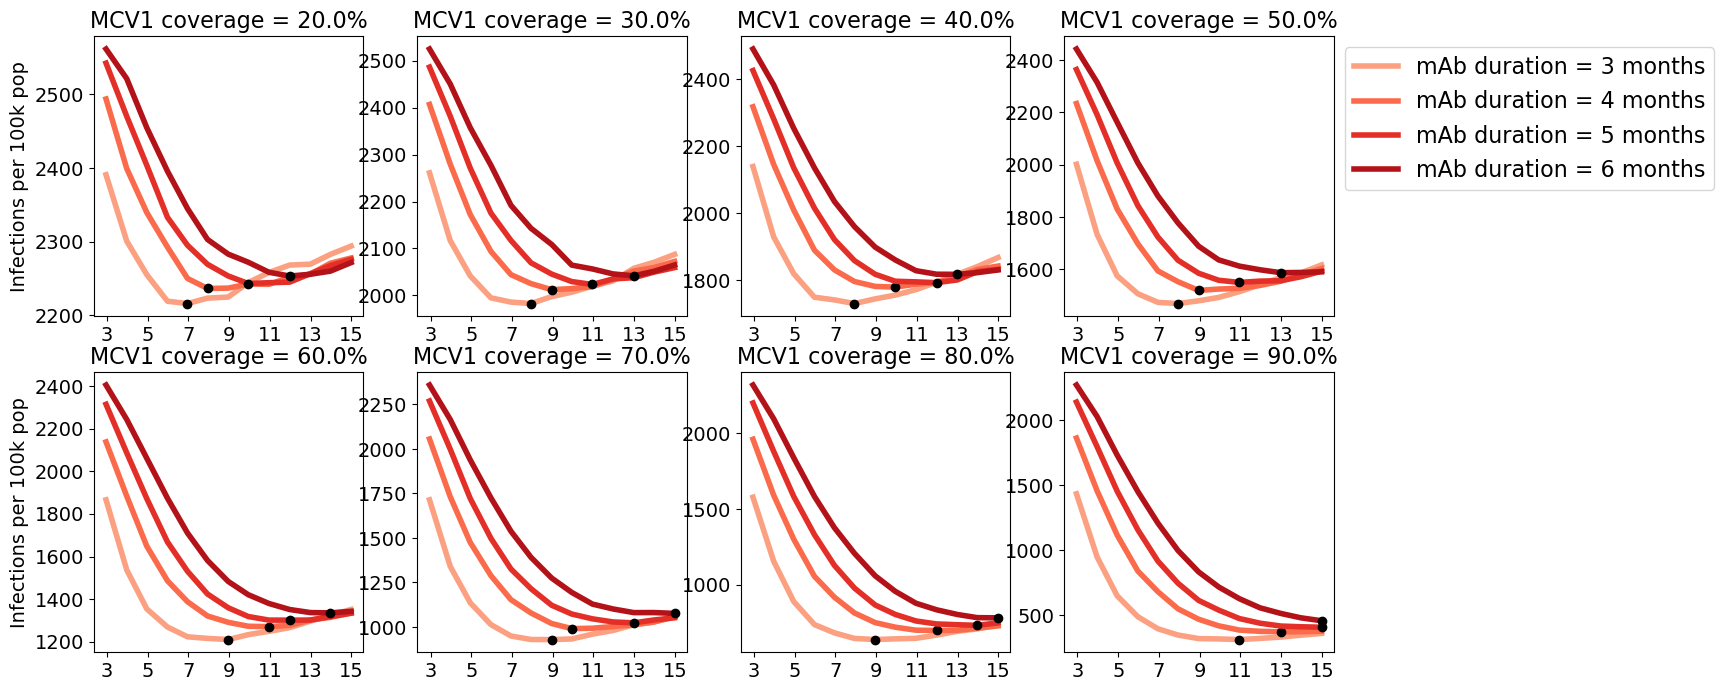

In [92]:
def vx_model_plots(selected_rows, var2plot = 'Inf_mean_nrm'):

    # Plotting
    fig, axs = plt.subplots(2, 4, figsize = (16, 8))

    # Get unique values of 'MCV1' to plot separate lines
    i = -1
    for mcv1_value in [.2, .3, .4, .5, .6, .7, .8, .9]:
        subset1 = selected_rows[selected_rows['MCV1'] == mcv1_value].reset_index()
        i = i+1
        ax = axs[int(np.floor(i/4)), i%4]
        mycmap1 = plt.get_cmap('Blues', 7)
        mycmap2 = plt.get_cmap('Reds', 7)
        flag = True
  #  for flag in [False, True]:
        j = 1
        for durations in [90.0, 120.0, 150.0, 180.0]:
            j = j+1
            # Filter rows for each MCV1 value
            # Sort rows by 'MCV1_age' to get a proper line plot
            if flag: 
                #mylabel = 'no mAb-independent age effect'
                mylabel = 'mAb duration = ' + str(int(durations/30)) + ' months'
                subset = subset1[(subset1['Ageind_vx_model'] == flag) & (subset1['mat_factor_vx']==1.0) & (subset1['mat_duration']==durations)].reset_index()
                mycolor = mycmap2(j)
            else:
                #mylabel = 'age and mAbs affect efficacy'
                subset = subset1[(subset1['Ageind_vx_model'] == flag) & (subset1['mat_factor_vx']==0.4) & (subset1['mat_duration']==durations)].reset_index()
                mycolor = mycmap1(j)
            subset = subset.sort_values('MCV1_age')

            # Plot 'Infs' vs. 'MCV1_age' for the current MCV1 value
            ax.plot(subset['MCV1_age'], subset[var2plot], label=mylabel, color=mycolor, linewidth=4)
            yv = np.min(subset[var2plot])
            xv = np.argmin(subset[var2plot])
            ax.plot(subset['MCV1_age'][xv], yv, 'k.', markersize=12)
            ax.set_xticks([30.5*i for i in range(3, 16, 2)])
            ax.set_xticklabels([str(i) for i in range(3, 16, 2)], fontsize=14)
        ax.set_title('MCV1 coverage = '+str(100*mcv1_value)+'%', fontsize=16)
        if i == 3:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 16)
        if i%4==0:
            ax.set_ylabel('Infections per 100k pop', fontsize = 14)
        ax.tick_params(axis='y', which='major', labelsize=14)
    return (fig, axs)

new_cut = (grouped_df['start_year']==2040) & \
(grouped_df['mat_factor_inf']==1.0) & \
(grouped_df['MCV2_age']==1.25*365) & \
(grouped_df['MCV2']==0.0) & \
(grouped_df['timeliness_distribution']== True)


selected_rows = grouped_df[(grouped_df['R0'] == 16.0) & new_cut]
(fig, axs) = vx_model_plots(selected_rows)
fig.savefig('MCV1_curves_ageindependent_vx_model.svg', format='svg', dpi=1000, bbox_inches='tight')


In [417]:
selected_rows

R0  MCV1  MCV1_age  mat_factor_inf  mat_factor_vx  mat_duration  MCV2  \
281   16.0   0.0      90.0             1.0            0.4         120.0   0.0   
291   16.0   0.0      90.0             1.0            1.0         120.0   0.0   
292   16.0   0.0      90.0             1.0            1.0         120.0   0.0   
304   16.0   0.0     121.0             1.0            0.4         120.0   0.0   
314   16.0   0.0     121.0             1.0            1.0         120.0   0.0   
...    ...   ...       ...             ...            ...           ...   ...   
3664  16.0   1.0     426.0             1.0            1.0         120.0   0.0   
3665  16.0   1.0     426.0             1.0            1.0         120.0   0.0   
3677  16.0   1.0     457.0             1.0            0.4         120.0   0.0   
3687  16.0   1.0     457.0             1.0            1.0         120.0   0.0   
3688  16.0   1.0     457.0             1.0            1.0         120.0   0.0   

      MCV2_age  start_year  timeliness_distribution  Ageind_vx_model  \
281     456.25      2040.0                     True            False   
291     456.25      2040.0                     True            False   
292     456.25      2040.0                     True             True   
304     456.25      2040.0                     True            False   
314     456.25      2040.0                     True            False   
...        ...         ...                      ...              ...   
3664    456.25      2040.0                     True            False   
3665    456.25      2040.0                     True             True   
3677    456.25      2040.0                     True            False   
3687    456.25      2040.0                     True            False   
3688    456.25      2040.0                     True             True   

      Inf_mean_nrm  
281     222.649104  
291     222.759160  
292     222.832726  
304     222.548904  
314     223.048435  
...            ...  
3664      4.760174  
3665      2.287909  
3677      2.863104  
3687      4.014837  
3688      2.322186  

[559 rows x 12 columns]

In [59]:
def age_hists(selected_rows, ages):
    fig, ax = plt.subplots()
    age_hist_bins = [i/12.0 for i in range(25)] + [2.25+i/4 for i in range(12)] + [6+i for i in range(24)]
    # Get unique values of 'MCV1' to plot separate lines
    mycmap = plt.get_cmap('Reds', 2+len(ages))
    i = 0
    for mcv1age in ages:
        i = i+1
        # Filter rows for each MCV1 value
        subset = selected_rows[selected_rows['MCV1_age'] == mcv1age].reset_index()


        # plot 'Infs' vs. 'MCV1_age' for the current MCV1 value
        ax.plot([12*i for i in age_hist_bins[:-1]], subset['age_hists_mean'][0]/np.diff(age_hist_bins)/12, label=f'MCV1 age = {np.floor(mcv1age/30)}', 
               color=mycmap(i))
    #    yv = np.min(subset['Inf_mean_nrm'])
    #    xv = np.argmin(subset['Inf_mean_nrm'])
    #    ax.plot(subset['MCV1_age'][xv], yv, 'k.')

    # Set the title and labels
    ax.set_title('Infections vs. age at MCV1 vaccination')
    ax.set_xlabel('Age at infection (years)')
    ax.set_ylabel('Mean annual Infections in age bin')
    #ax.set_xticks([30.5*i for i in range(3, 16)])
    #ax.set_xticklabels([str(i) for i in range(3, 16)])
    ax.set_xlim(0, 24)
    # Show legend
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    return (fig, ax)


def age_hists_norm(selected_rows, ages):
    fig, ax = plt.subplots()
    age_hist_bins = [i/12.0 for i in range(25)] + [2.25+i/4 for i in range(12)] + [6+i for i in range(24)]
    # Get unique values of 'MCV1' to plot separate lines
    mycmap = plt.get_cmap('Reds', len(ages))
    i = -1
    for mcv1age in ages:
        i = i+1
        # Filter rows for each MCV1 value
        subset = selected_rows[selected_rows['MCV1_age'] == mcv1age].reset_index()


        # plot 'Infs' vs. 'MCV1_age' for the current MCV1 value
        ax.plot([12*i for i in age_hist_bins[:-1]], subset['age_hists_mean'][0]/np.diff(age_hist_bins)/np.sum(subset['age_hists_mean'][0]/np.diff(age_hist_bins)), label=f'MCV1 age = {np.floor(mcv1age/30)}', 
               color=mycmap(i))
    #    yv = np.min(subset['Inf_mean_nrm'])
    #    xv = np.argmin(subset['Inf_mean_nrm'])
    #    ax.plot(subset['MCV1_age'][xv], yv, 'k.')

    # Set the title and labels
    ax.set_title('Normalized Infections vs. age at MCV1 vaccination')
    ax.set_xlabel('Age at infection (years)')
    ax.set_ylabel('Fraction of Infections in age bin')
    #ax.set_xticks([30.5*i for i in range(3, 16)])
    #ax.set_xticklabels([str(i) for i in range(3, 16)])
    ax.set_xlim(0, 24)
    # Show legend
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    return (fig, ax)


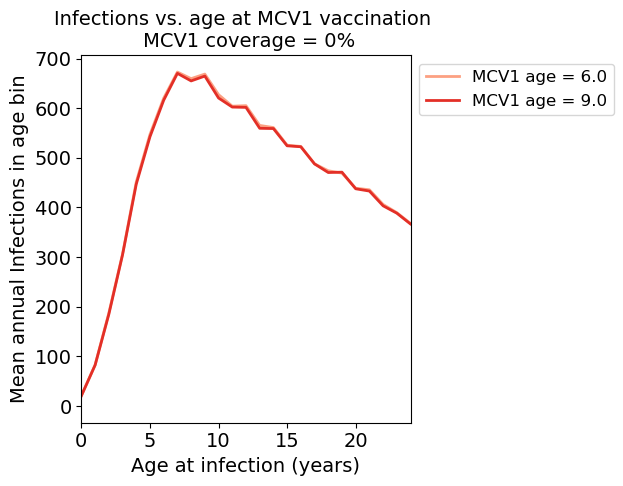

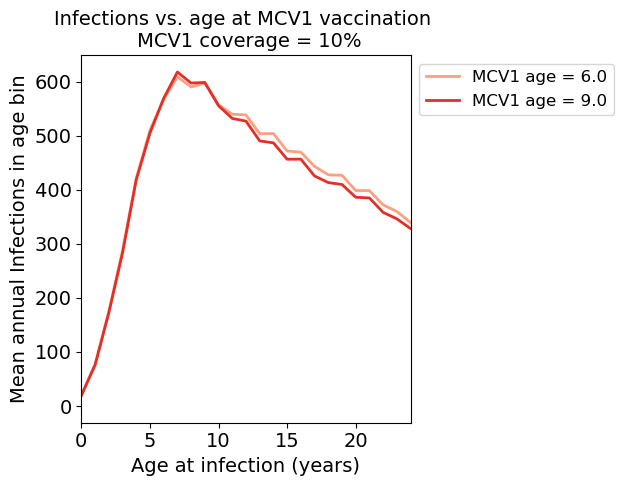

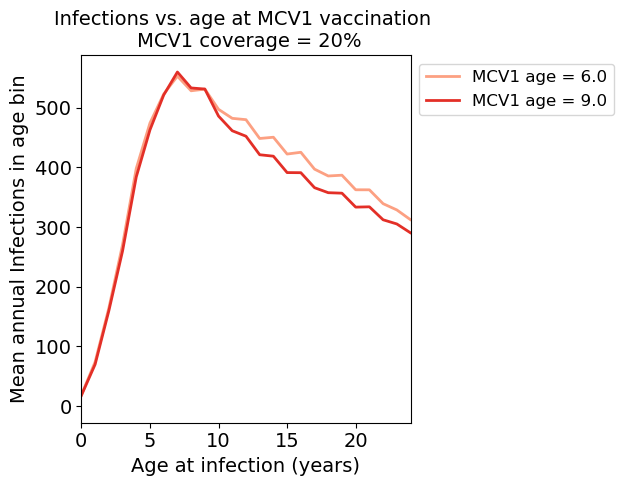

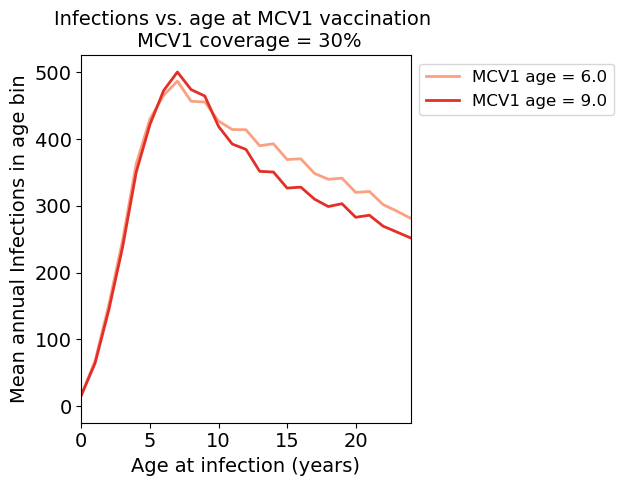

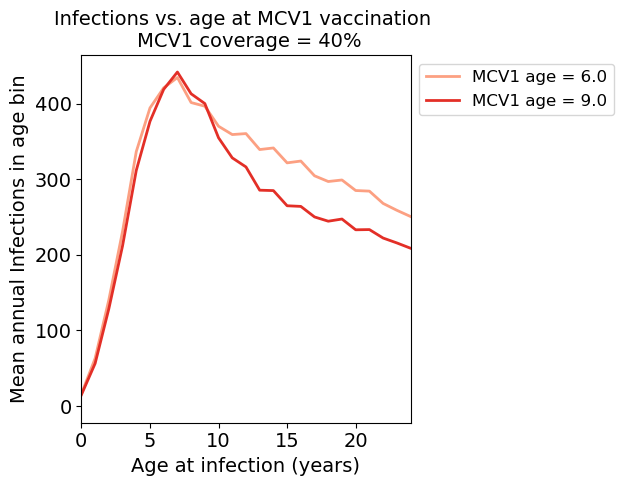

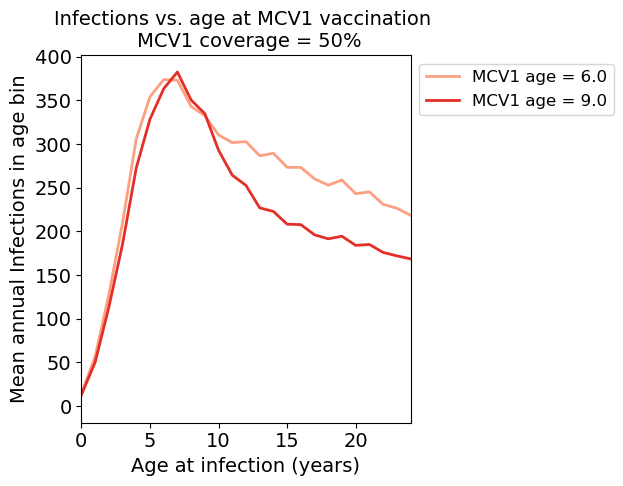

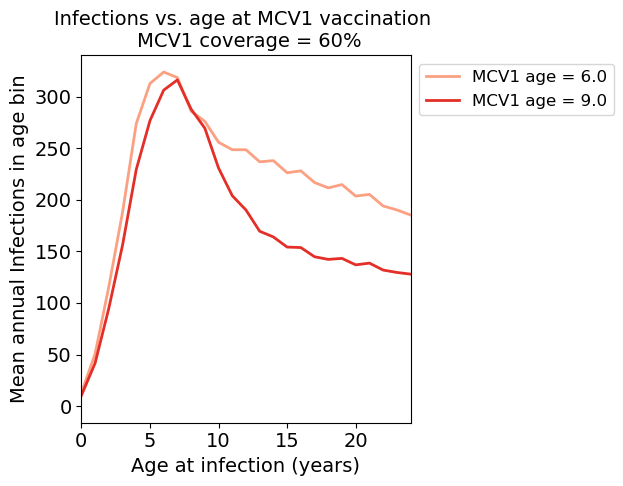

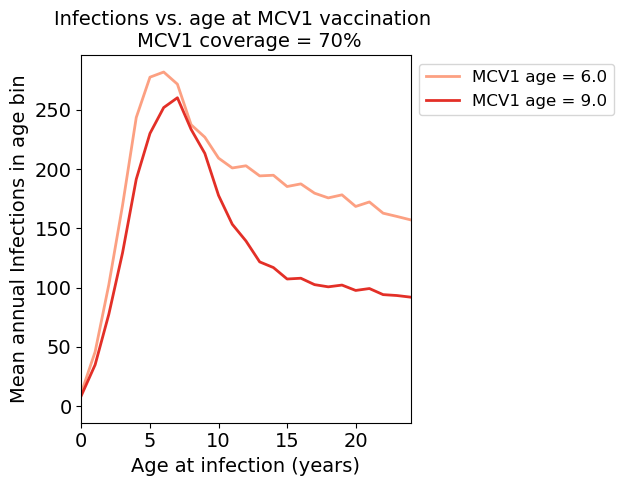

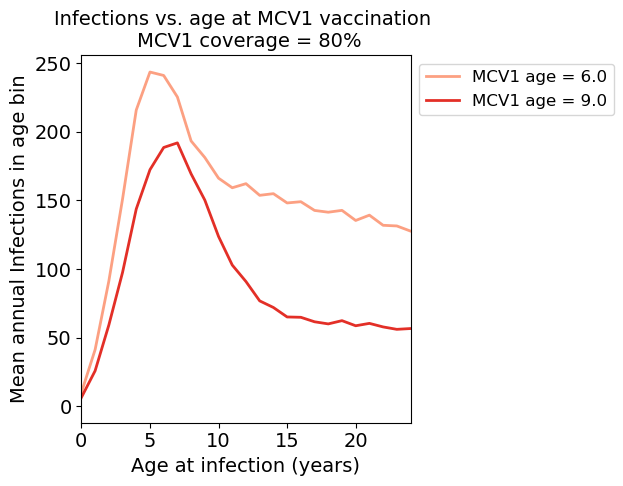

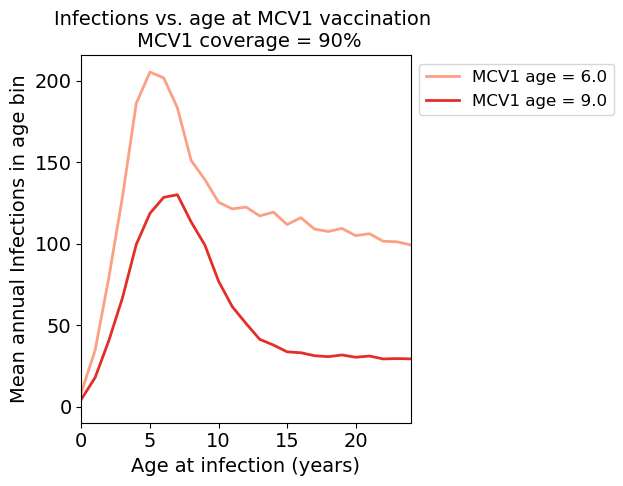

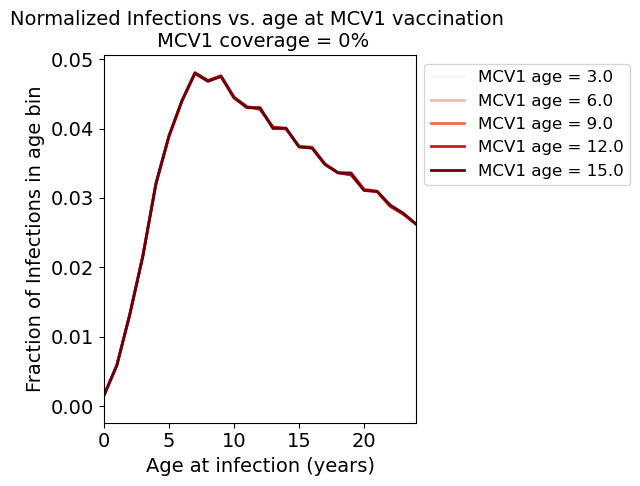

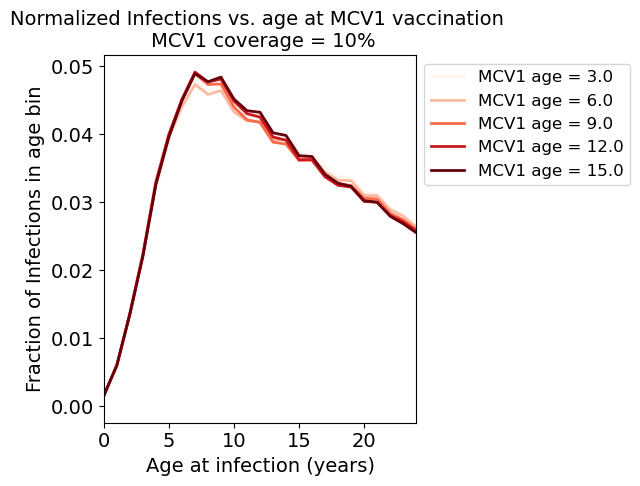

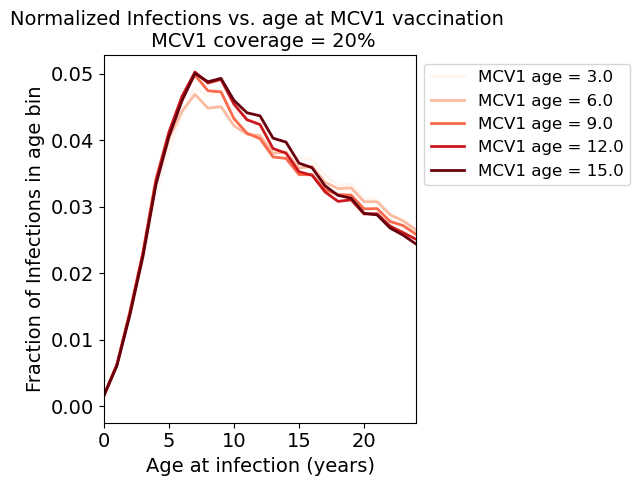

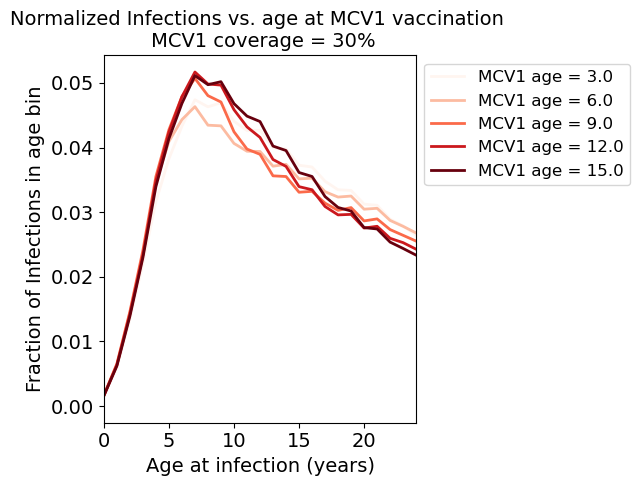

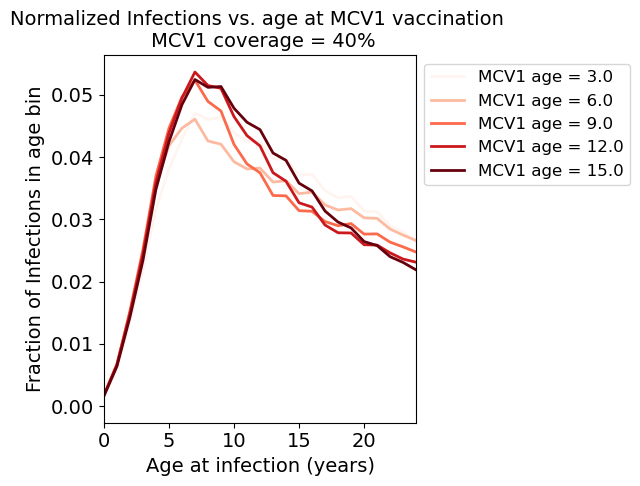

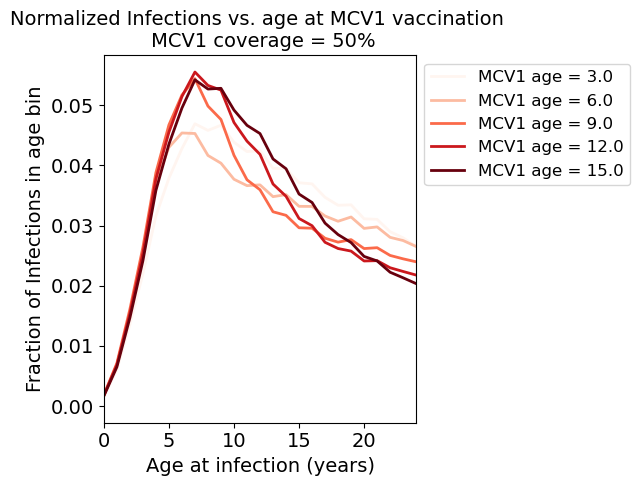

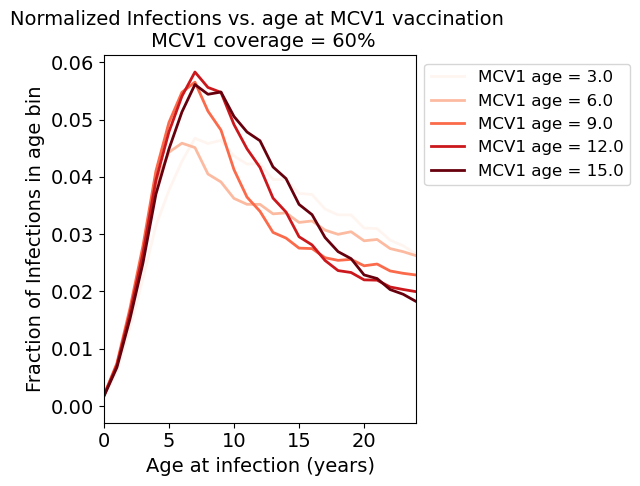

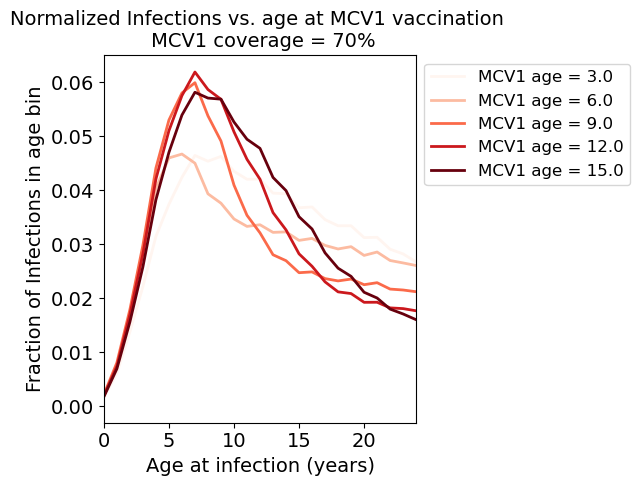

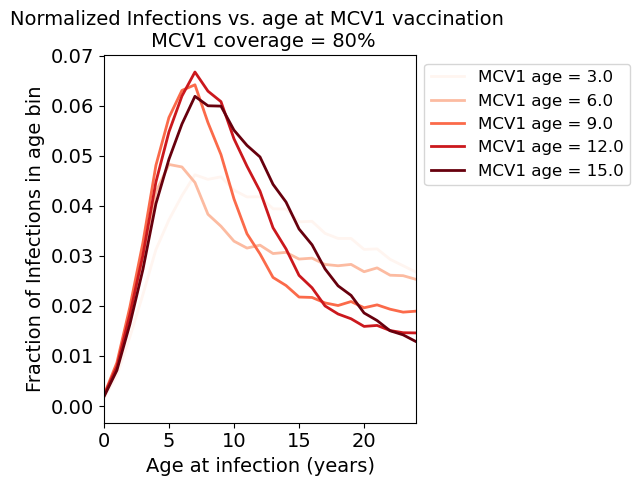

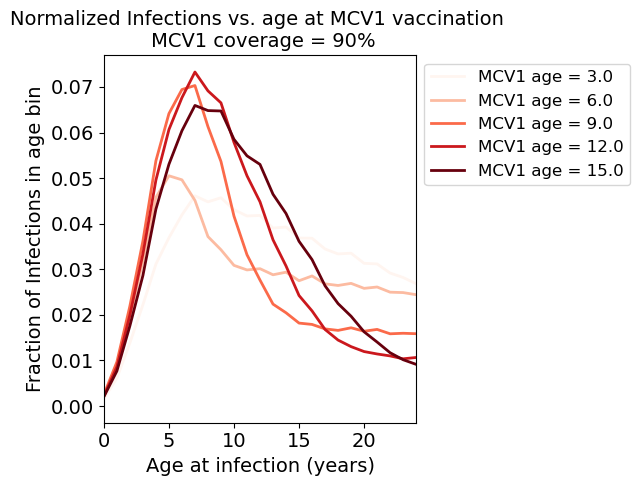

In [60]:
# Select rows where 'R0' is 16.0, all MCV1 values, no MCV2
base_cut = (grouped_df['mat_duration']==120.0) & \
(grouped_df['MCV2']==0.0) & \
(grouped_df['mat_factor_inf']==1.0) & \
(grouped_df['mat_factor_vx']==0.4) & \
(grouped_df['MCV2_age']==1.25*365) & \
(grouped_df['start_year']==2040.0) & \
(grouped_df['timeliness_distribution'] == True) & \
(grouped_df['Ageind_vx_model']== False)

for MCV1 in [i/10 for i in range(10)]:
    selected_rows = grouped_df[(age_df['R0'] == 16.0) & (grouped_df['MCV1']==MCV1) & base_cut]
    (fig, ax) = age_hists(selected_rows, np.unique(selected_rows['MCV1_age'])[[3, 6]])
    ax.set_title('Infections vs. age at MCV1 vaccination \n MCV1 coverage = '+str(int(100*MCV1))+'%')

    plt.show()

    fig.savefig('MCV0_Agehists_R016_Cov'+str(int(100*MCV1))+'.svg', format='svg', dpi=1000)
    
    
for MCV1 in [i/10 for i in range(10)]:
    selected_rows = grouped_df[(age_df['R0'] == 16.0) & (grouped_df['MCV1']==MCV1) & base_cut]
    (fig, ax) = age_hists_norm(selected_rows, np.unique(selected_rows['MCV1_age'])[::3])
    ax.set_title('Normalized Infections vs. age at MCV1 vaccination \n MCV1 coverage = '+str(int(100*MCV1))+'%')

    plt.show()

    fig.savefig('MCV0_Agehists_norm_R016_Cov'+str(int(100*MCV1))+'.svg', format='svg', dpi=1000)

(0.0, 24.0)

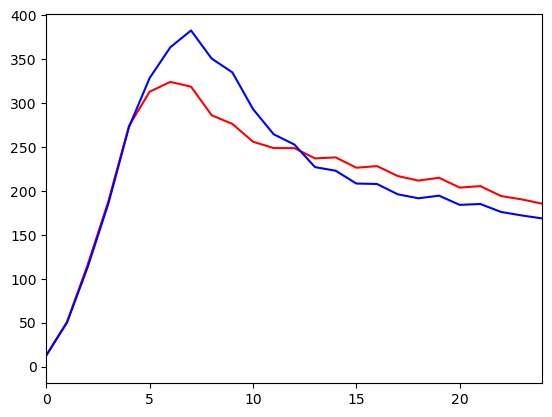

In [336]:
#Compare at equal # of infections
row1 = grouped_df[(grouped_df['R0'] == 16.0) & (grouped_df['MCV1']==0.6) & (grouped_df['MCV1_age'] == 182.0) & base_cut].reset_index()
row2 = grouped_df[(grouped_df['R0'] == 16.0) & (grouped_df['MCV1']==0.5) & (grouped_df['MCV1_age'] == 273.0) & base_cut].reset_index()

fig, ax = plt.subplots()
ax.plot([12*i for i in age_hist_bins[:-1]], row1['age_hists_mean'][0]/np.diff(age_hist_bins)/12, 'r')
ax.plot([12*i for i in age_hist_bins[:-1]], row2['age_hists_mean'][0]/np.diff(age_hist_bins)/12, 'b')
ax.set_xlim(0, 24)

In [411]:
row1['age_hists_mean'][0].sum()
row2['age_hists_mean'][0].sum()





12752.385

In [286]:

None is False

False

In [287]:
mydict.get('Age') is False

False

In [289]:
if mydict.get('Age') is False:
    print('None is False')